In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkt
import geopandas as gpd
from sklearn.neighbors import NearestNeighbors
from scipy.stats import pearsonr
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from shapely.geometry import Point
from tqdm import tqdm  # Add progress bar

In [10]:
# Helper function for map plotting
def create_colormap():
    return LinearSegmentedColormap.from_list("custom_cmap", 
                                           ['blue', 'white', 'red'], 
                                           N=256)

# 1. Load & prepare data -------------------------------------------------------------
print("Loading and preparing data...")
df = pd.read_csv('./Electric_Vehicle_Population_Data.csv')
df.dropna(inplace=True)

# Display dataset information
print("\nDataset Information:")
print(f"Number of records: {len(df)}")
print(f"Columns: {df.columns.tolist()}")

Loading and preparing data...

Dataset Information:
Number of records: 239176
Columns: ['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year', 'Make', 'Model', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range', 'Base MSRP', 'Legislative District', 'DOL Vehicle ID', 'Vehicle Location', 'Electric Utility', '2020 Census Tract']


In [11]:
# Extract coordinates from POINT strings
df['Longitude'] = df['Vehicle Location'].str.extract(r'POINT \(([^ ]+)')[0].astype(float)
df['Latitude'] = df['Vehicle Location'].str.extract(r'POINT \([^)]+ ([^)]+)')[0].astype(float)
df.dropna(subset=['Longitude', 'Latitude'], inplace=True)
df['geometry'] = df.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326").to_crs(epsg=3857)
coords = np.vstack([gdf.geometry.x, gdf.geometry.y]).T
y = gdf['Electric Range'].values
n = len(y)

print(f"\nExtracted {n} point locations with Electric Range values")


Extracted 239176 point locations with Electric Range values


In [12]:
print(df['State'].unique())

['WA']


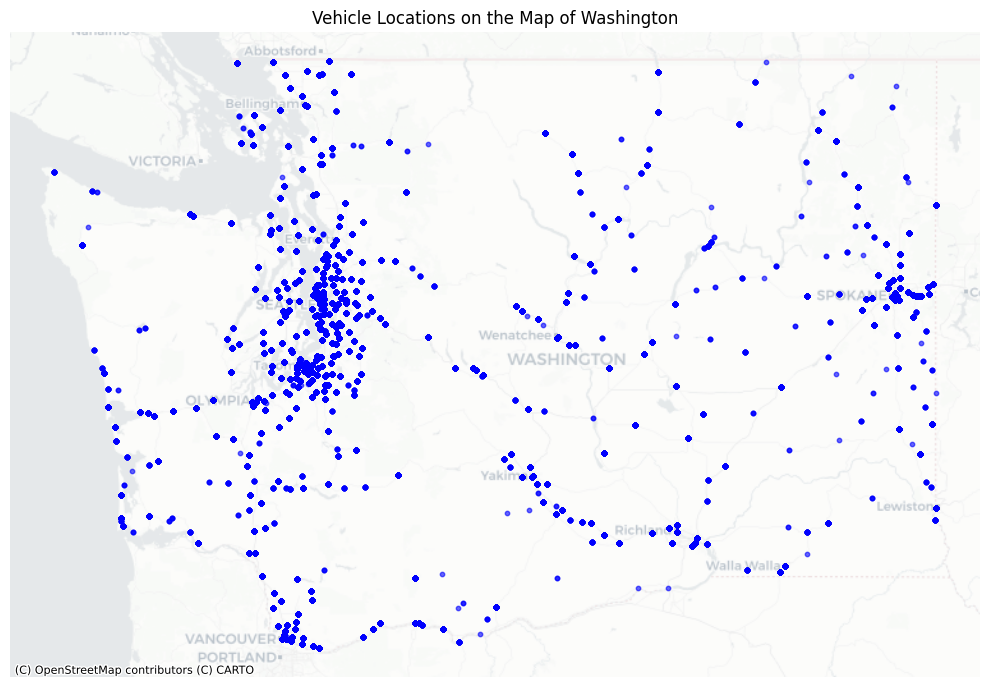

In [5]:
import contextily as ctx

fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, markersize=10, c='blue', alpha=0.6)

# Add CartoDB Positron basemap with valid zoom
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='EPSG:3857', alpha=0.6)

ax.set_axis_off()
plt.title("Vehicle Locations on the Map of Washington")
plt.tight_layout()
plt.show()

C:\Users\Rohit\AppData\Local\Temp\ipykernel_30728\870754408.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlBu_r')  # Reversed so higher range = red, lower = blue


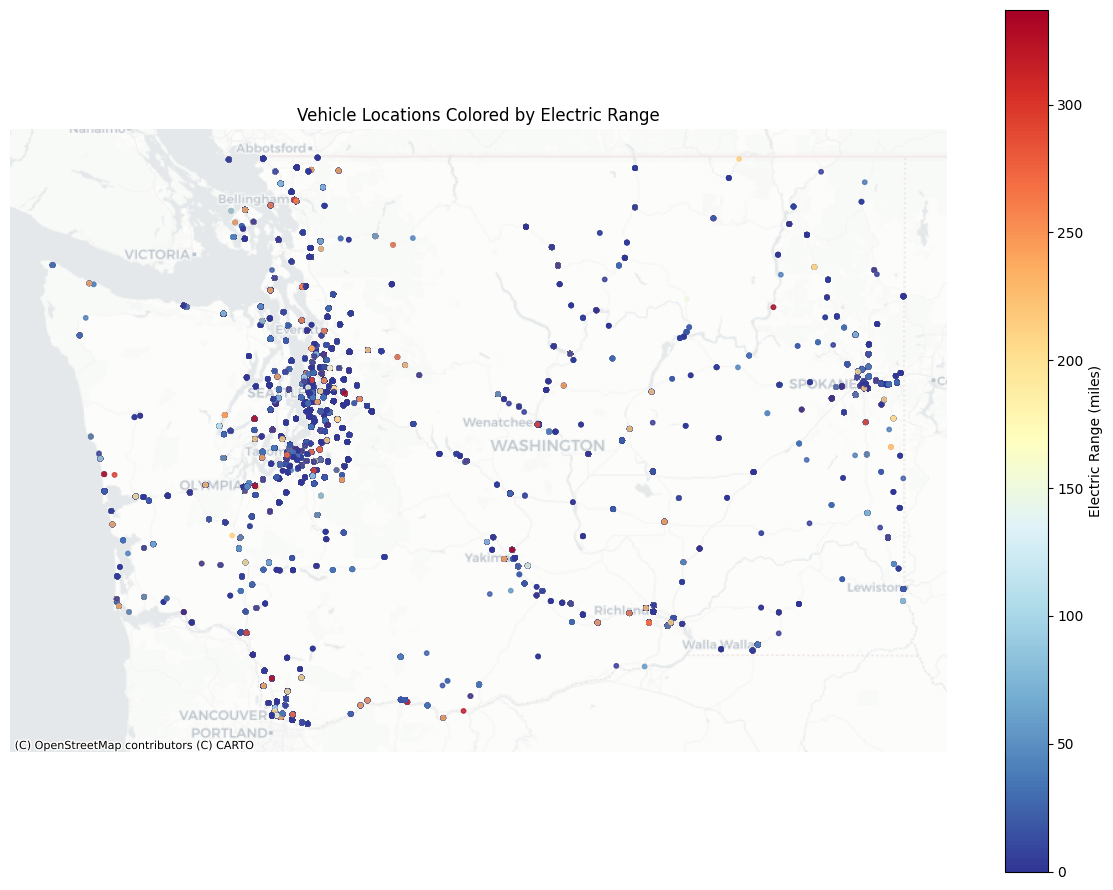

In [6]:
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import cm

# Create color map and normalization
cmap = cm.get_cmap('RdYlBu_r')  # Reversed so higher range = red, lower = blue
norm = Normalize(vmin=gdf['Electric Range'].min(), vmax=gdf['Electric Range'].max())

# Plot
fig, ax = plt.subplots(figsize=(12, 9))
gdf.plot(
    ax=ax,
    markersize=10,
    column='Electric Range',  # color by Electric Range
    cmap=cmap,
    norm=norm,
    legend=False,
    alpha=0.8
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs, alpha=0.6)

# Add colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # required workaround for ScalarMappable with no mappable data
cbar = fig.colorbar(sm, ax=ax, label='Electric Range (miles)')

ax.set_axis_off()
plt.title("Vehicle Locations Colored by Electric Range")
plt.tight_layout()
plt.show()

In [7]:
# 2. Summary statistics of Electric Range ---------------------------------------------
print("\n2. Summary Statistics of Electric Range:")
range_stats = gdf['Electric Range'].describe()
print(range_stats)


2. Summary Statistics of Electric Range:
count    239176.000000
mean         45.548972
std          83.419312
min           0.000000
25%           0.000000
50%           0.000000
75%          38.000000
max         337.000000
Name: Electric Range, dtype: float64


In [8]:
# 3. Use KNN instead of full distance matrices ----------------------------------------
print("\n3. Using K-Nearest Neighbors instead of full distance matrices...")
# Use KNN for finding neighbors (much more memory efficient)
k = 6  # 5 neighbors + self
nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coords)
distances, indices = nbrs.kneighbors(coords)

# Create a sparse-like representation of the distance matrix
# We only store distances to the k nearest neighbors
neighbors_dict = {i: indices[i, 1:] for i in range(n)}  # Skip first neighbor (self)
distances_dict = {i: distances[i, 1:] for i in range(n)}  # Skip first distance (0)

print(f"K-NN computed for {n} points (k={k-1})")


3. Using K-Nearest Neighbors instead of full distance matrices...
K-NN computed for 239176 points (k=5)


In [9]:
# 4. Spatial weights matrices (KNN-based) ---------------------------------------------
print("\n4. Creating Spatial Weights Matrix using KNN...")

# Create KNN weights matrix (as a dictionary for memory efficiency)
W_knn_dict = {}
for i in range(n):
    # Assign weight 1 to the k nearest neighbors
    W_knn_dict[i] = {j: 1 for j in indices[i, 1:]}  # Skip first neighbor (self)

# Row-standardize (normalize weights)
for i in range(n):
    total = sum(W_knn_dict[i].values())
    if total > 0:  # Avoid division by zero
        for j in W_knn_dict[i]:
            W_knn_dict[i][j] /= total

print("K-NN weights created and row-standardized")


4. Creating Spatial Weights Matrix using KNN...
K-NN weights created and row-standardized


In [10]:
import numpy as np

strata_col = 'Model Year'
groups = gdf.groupby(strata_col)['Electric Range']

# Only keep strata with at least 2 observations
valid_counts = groups.count() >= 2
valid_strata = valid_counts[valid_counts].index  # names of strata with >=2

# Recompute means, vars, counts for only valid strata
group_means  = groups.mean().loc[valid_strata]
group_vars   = groups.var(ddof=0).loc[valid_strata]   # ddof=0 for population var
group_counts = groups.count().loc[valid_strata]

overall_mean = gdf['Electric Range'].mean()

# Between‐strata (inter) SS
inter_var = (group_counts * (group_means - overall_mean)**2).sum()

# Within‐strata (intra) SS
intra_var = (group_counts * group_vars).sum()

q_stat = inter_var / (inter_var + intra_var)
print(f"q-statistic (Model): {q_stat:.4f}")

q-statistic (Model): 0.7012


Optimal bandwidth using Scott's rule: 13862.39 meters
Using bandwidth: 41587.17 meters


Scoring KDE Grid: 100%|██████████| 18/18 [10:15<00:00, 34.17s/it]


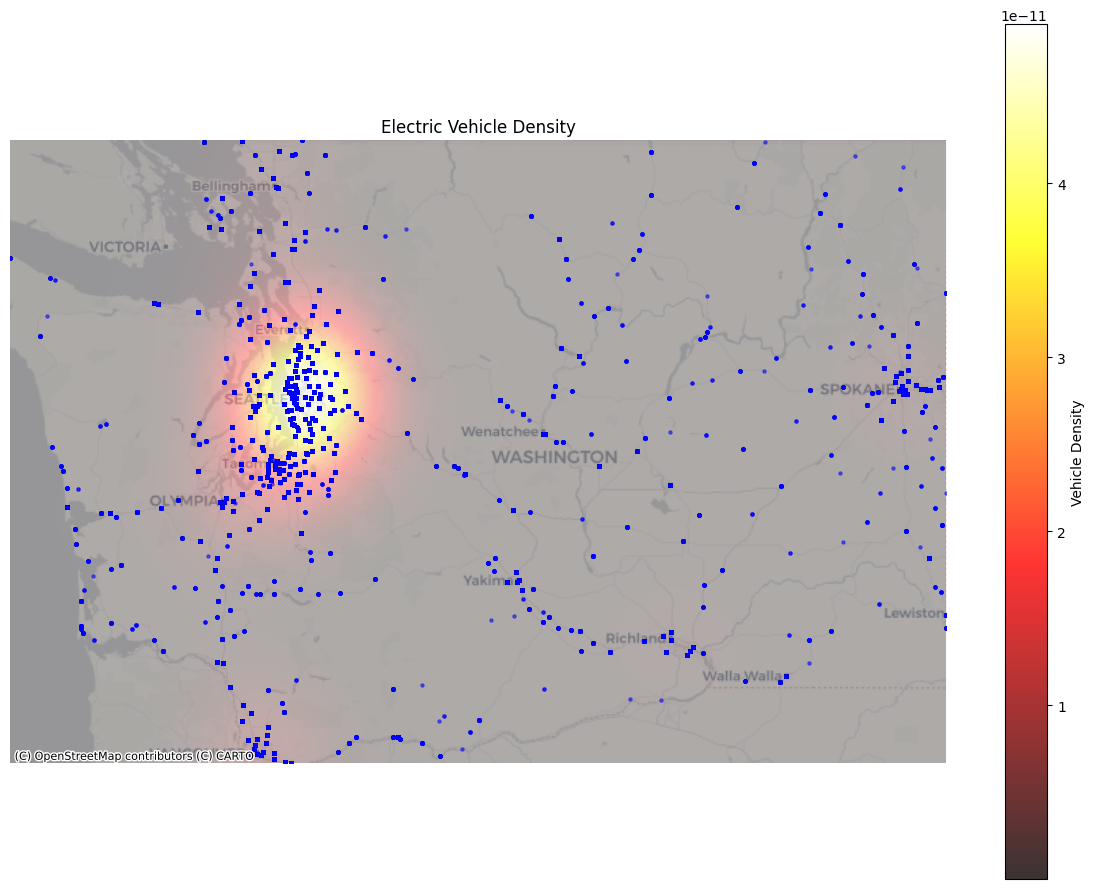

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import contextily as ctx
from tqdm import tqdm

# Helper function for batched KDE scoring with progress
def batched_score_samples(kde, grid_points, batch_size=5000):
    """Vectorized KDE scoring with tqdm progress bar"""
    n_total = grid_points.shape[0]
    scores = []
    for i in tqdm(range(0, n_total, batch_size), desc="Scoring KDE Grid"):
        batch = grid_points[i:i + batch_size]
        scores.append(kde.score_samples(batch))
    return np.hstack(scores)

# --- 1. Define spatial grid for KDE -----------------------------------------
# Bounds for the grid
x_min, x_max = gdf.geometry.x.min(), gdf.geometry.x.max()
y_min, y_max = gdf.geometry.y.min(), gdf.geometry.y.max()

# Grid resolution
grid_size = 300
x_grid = np.linspace(x_min, x_max, grid_size)
y_grid = np.linspace(y_min, y_max, grid_size)
xx, yy = np.meshgrid(x_grid, y_grid)
grid_points = np.vstack([xx.ravel(), yy.ravel()]).T

# --- 2. KDE setup -----------------------------------------------------------
# Use Scott's Rule to determine bandwidth
n_samples = len(coords)
d = 2  # dimensions (x, y)
bandwidth_scott = n_samples ** (-1 / (d + 4)) * np.std(coords, axis=0).mean()
print(f"Optimal bandwidth using Scott's rule: {bandwidth_scott:.2f} meters")

# Optional multiplier to smooth the result
bandwidth = bandwidth_scott * 3
print(f"Using bandwidth: {bandwidth:.2f} meters")

# Fit KDE
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde.fit(coords)

# --- 3. KDE evaluation with tqdm --------------------------------------------
log_density = batched_score_samples(kde, grid_points, batch_size=5000)
z_density = np.exp(log_density).reshape(xx.shape)

# --- 4. Plot KDE results -----------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 9))

# Heatmap
kde_plot = ax.imshow(
    z_density,
    origin='lower',
    extent=(x_min, x_max, y_min, y_max),
    cmap='hot',
    alpha=0.8
)

# Plot points (optional overlay)
gdf.plot(ax=ax, markersize=5, color='blue', alpha=0.5)

# Basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs, alpha=0.6)

# Colorbar
cbar = plt.colorbar(kde_plot, ax=ax, label='Vehicle Density')
ax.set_axis_off()
plt.title("Electric Vehicle Density")
plt.tight_layout()
plt.show()

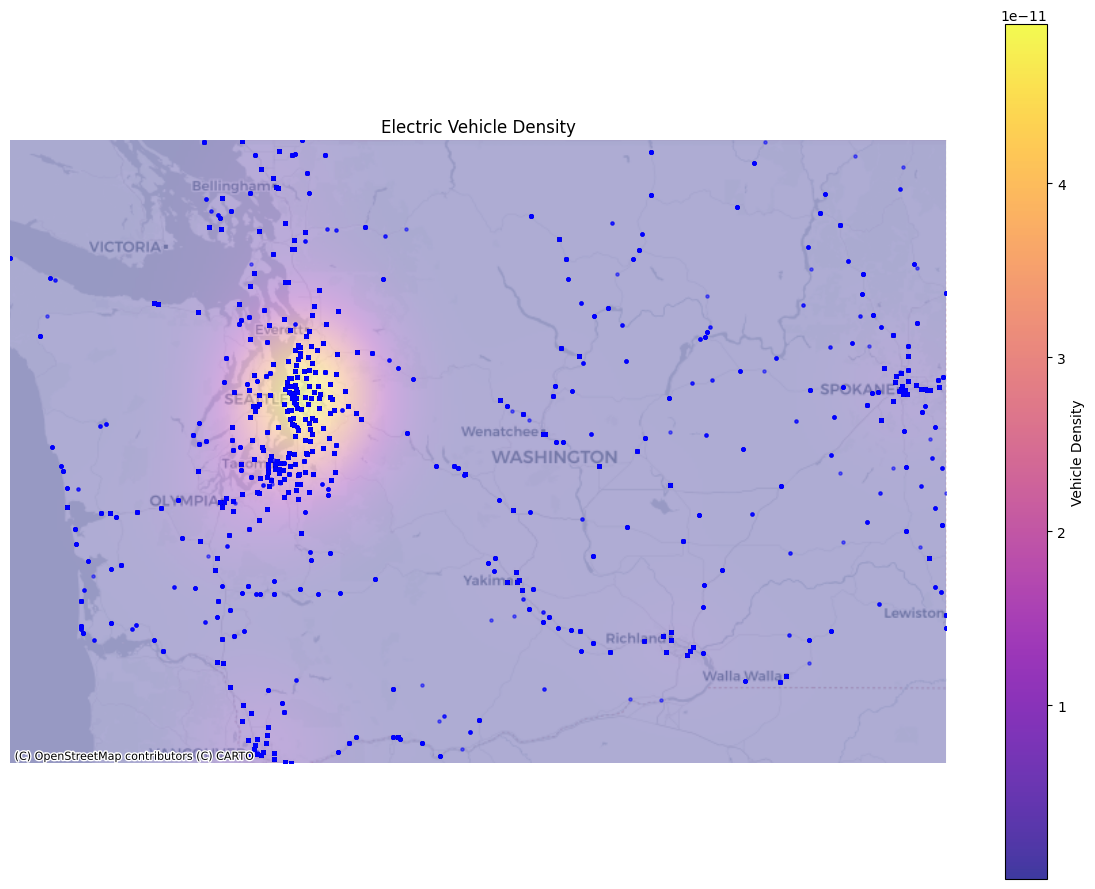

In [12]:
fig, ax = plt.subplots(figsize=(12, 9))

# Heatmap
kde_plot = ax.imshow(
    z_density,
    origin='lower',
    extent=(x_min, x_max, y_min, y_max),
    cmap='plasma',
    alpha=0.8
)

# Plot points (optional overlay)
gdf.plot(ax=ax, markersize=5, color='blue', alpha=0.5)

# Basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs, alpha=0.6)

# Colorbar
cbar = plt.colorbar(kde_plot, ax=ax, label='Vehicle Density')
ax.set_axis_off()
plt.title("Electric Vehicle Density")
plt.tight_layout()
plt.show()

In [17]:
import numpy as np
from scipy.spatial import KDTree

# Function to estimate values at grid points using inverse distance weighting with KDTree
def idw_interpolation_kdtree(grid_points, data_points, values, power=2, k_neighbors=50):
    # Create KDTree for fast nearest neighbor search
    tree = KDTree(data_points)
    
    # Initialize an array to store interpolated values
    interpolated_values = np.zeros(len(grid_points))
    
    # Loop through each grid point and compute the weighted average using a limited number of neighbors
    for i, point in enumerate(grid_points):
        distances, indices = tree.query(point, k=k_neighbors)  # Limit the number of neighbors
        
        # Avoid division by zero by replacing zero distances with a small value
        distances[distances == 0] = 1e-10
        
        # Compute the weights using inverse distance
        weights = 1.0 / (distances ** power)
        
        # Normalize weights for the grid point
        weights /= weights.sum()
        
        # Calculate the weighted average of the values
        interpolated_values[i] = np.dot(weights, values[indices])
    
    return interpolated_values
ev_range = gdf['Electric Range'].astype(float).values
# Interpolate electric range values at grid points using the KDTree-based IDW with limited neighbors
z_range = idw_interpolation_kdtree(grid_points, coords, ev_range, power=2, k_neighbors=50)

# Reshape the result to match the grid shape
z_range_grid = z_range.reshape(xx.shape)


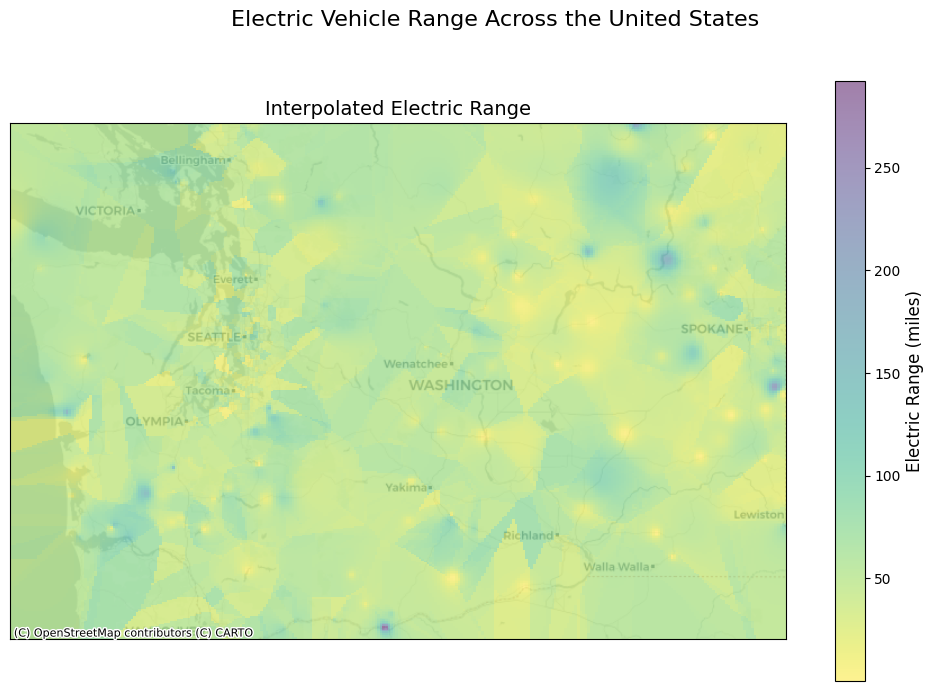

In [28]:
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Skip coordinate transformation and use original lat/lon directly
# This approach works if your data is already in WGS84 / EPSG:4326

# Create a figure
fig, ax = plt.subplots(figsize=(10, 7))

# Directly plot the data in original coordinates
pcm = ax.pcolormesh(xx, yy, z_range_grid, 
                   cmap='viridis_r', 
                   alpha=0.5,
                   shading='auto')

# Set the aspect to equal to avoid distortion
ax.set_aspect('equal')

# Explicitly set the axis to use geographic projection
ax.set_xlim(np.nanmin(xx), np.nanmax(xx))
ax.set_ylim(np.nanmin(yy), np.nanmax(yy))

# Add basemap with proper transformation
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs, alpha=1)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Add a colorbar
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('Electric Range (miles)', fontsize=12)

# Add titles
ax.set_title('Interpolated Electric Range', fontsize=14)
plt.suptitle('Electric Vehicle Range Across the United States', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

c:\Users\Rohit\miniconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Rohit\miniconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Rohit\miniconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Rohit\miniconda3\Lib\site-packages\sklearn\gaussian_process\kernels

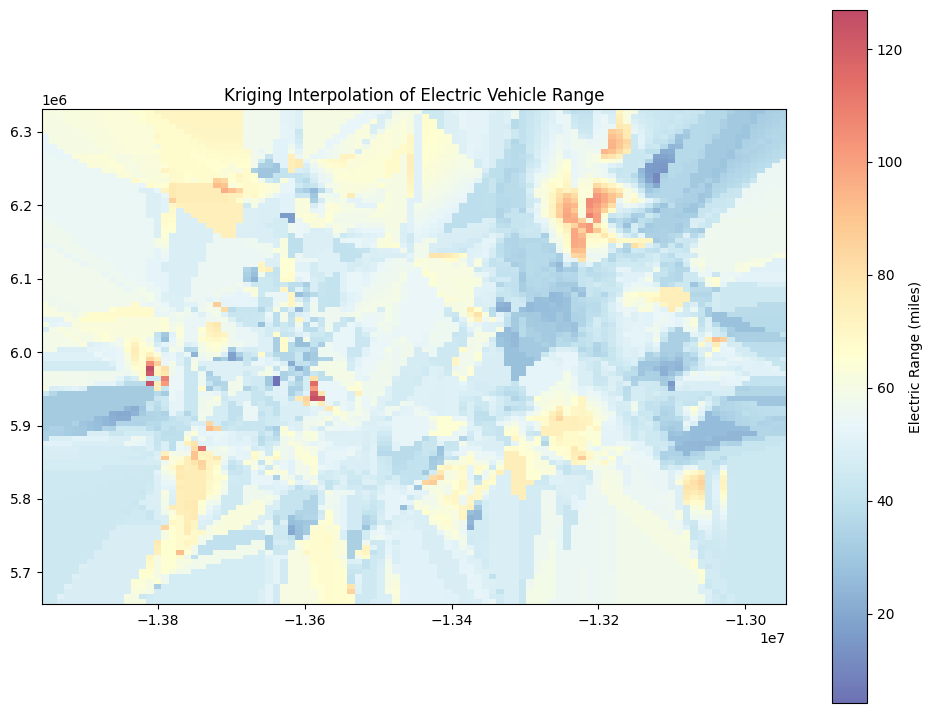

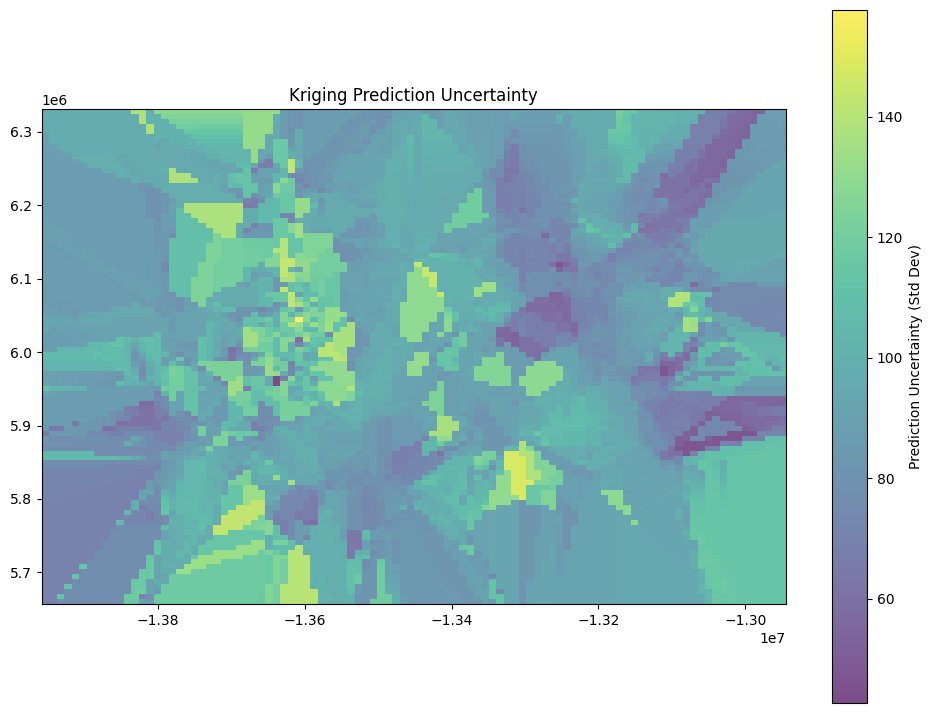

In [ ]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel
from scipy.spatial import KDTree

def kriging_interpolation_kdtree(grid_points, data_points, values, 
                                k_neighbors=100, nu=1.5, length_scale=1.0):
    """
    Performs kriging interpolation using KDTree for efficient local modeling.
    
    Parameters:
    -----------
    grid_points : array-like, shape (n_grid_points, 2)
        Points where to interpolate values
    data_points : array-like, shape (n_data_points, 2)
        Coordinates of data points
    values : array-like, shape (n_data_points,)
        Values at data points
    k_neighbors : int, default=100
        Number of neighboring points to use for local kriging
    nu : float, default=1.5
        Smoothness parameter for Matern kernel (0.5=exponential, 1.5=once differentiable)
    length_scale : float, default=1.0
        Initial length scale for the kernel
        
    Returns:
    --------
    interpolated_values : array, shape (n_grid_points,)
        Interpolated values at grid points
    uncertainty : array, shape (n_grid_points,)
        Prediction standard deviation at grid points
    """
    # Create KDTree for fast nearest neighbor search
    tree = KDTree(data_points)
    
    # Initialize arrays for interpolated values and uncertainty
    n_grid_points = len(grid_points)
    interpolated_values = np.zeros(n_grid_points)
    uncertainty = np.zeros(n_grid_points)
    
    # Define the kernel for kriging (Gaussian Process)
    # Matern kernel is standard for spatial data + WhiteKernel for noise
    kernel = Matern(length_scale=length_scale, nu=nu) + WhiteKernel(noise_level=1.0)
    
    # Initialize the Gaussian Process model
    gp = GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=2,  # Number of optimizer restarts
        normalize_y=True,        # Normalize target values
        random_state=42
    )
    
    # Process in batches to save memory
    batch_size = 1000
    n_batches = (n_grid_points + batch_size - 1) // batch_size
    
    for batch in range(n_batches):
        # Get current batch indices
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, n_grid_points)
        batch_indices = np.arange(start_idx, end_idx)
        
        # Process each point in the current batch
        for i, grid_idx in enumerate(batch_indices):
            point = grid_points[grid_idx]
            
            # Find k nearest neighbors
            distances, indices = tree.query(point, k=min(k_neighbors, len(data_points)))
            
            # Get the coordinates and values of these neighbors
            local_points = data_points[indices]
            local_values = values[indices]
            
            # Simple scaling to improve numerical stability
            # Scale coordinates relative to the current prediction point
            mean_coords = np.mean(local_points, axis=0)
            std_coords = np.std(local_points, axis=0)
            std_coords[std_coords == 0] = 1.0  # Avoid division by zero
            
            local_points_scaled = (local_points - mean_coords) / std_coords
            grid_point_scaled = (point - mean_coords) / std_coords
            
            # Fit the GP model on local data
            gp.fit(local_points_scaled, local_values)
            
            # Predict at the grid point
            pred_value, pred_std = gp.predict(grid_point_scaled.reshape(1, -1), return_std=True)
            
            # Store results
            interpolated_values[grid_idx] = pred_value[0]
            uncertainty[grid_idx] = pred_std[0]
    
    return interpolated_values, uncertainty


# Example usage (similar to your IDW code):
# Get electric range values
ev_range = gdf['Electric Range'].astype(float).values

# Perform kriging interpolation
z_range, z_uncertainty = kriging_interpolation_kdtree(
    grid_points, 
    coords, 
    ev_range, 
    k_neighbors=100,
    nu=1.5,          # Smoothness parameter
    length_scale=1.0  # Initial length scale
)

# Reshape the results to match the grid shape
z_range_grid = z_range.reshape(xx.shape)
z_uncertainty_grid = z_uncertainty.reshape(xx.shape)

# Visualize the interpolated surface
fig, ax = plt.subplots(figsize=(12, 9))
im = ax.imshow(
    z_range_grid,
    extent=(x_min, x_max, y_min, y_max),
    origin='lower',
    cmap='RdYlBu_r',
    alpha=0.7
)
cbar = fig.colorbar(im, ax=ax, label='Electric Range (miles)')
ax.set_title('Kriging Interpolation of Electric Vehicle Range')
plt.show()

# Visualize the uncertainty
fig, ax = plt.subplots(figsize=(12, 9))
im = ax.imshow(
    z_uncertainty_grid,
    extent=(x_min, x_max, y_min, y_max),
    origin='lower',
    cmap='viridis',
    alpha=0.7
)
cbar = fig.colorbar(im, ax=ax, label='Prediction Uncertainty (Std Dev)')
ax.set_title('Kriging Prediction Uncertainty')
plt.show()

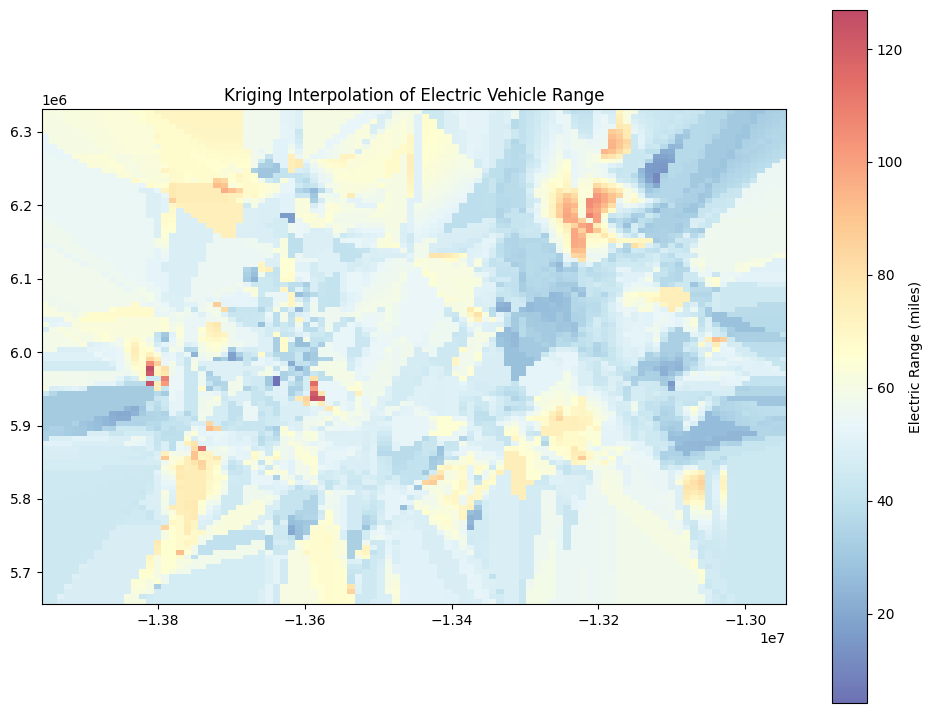

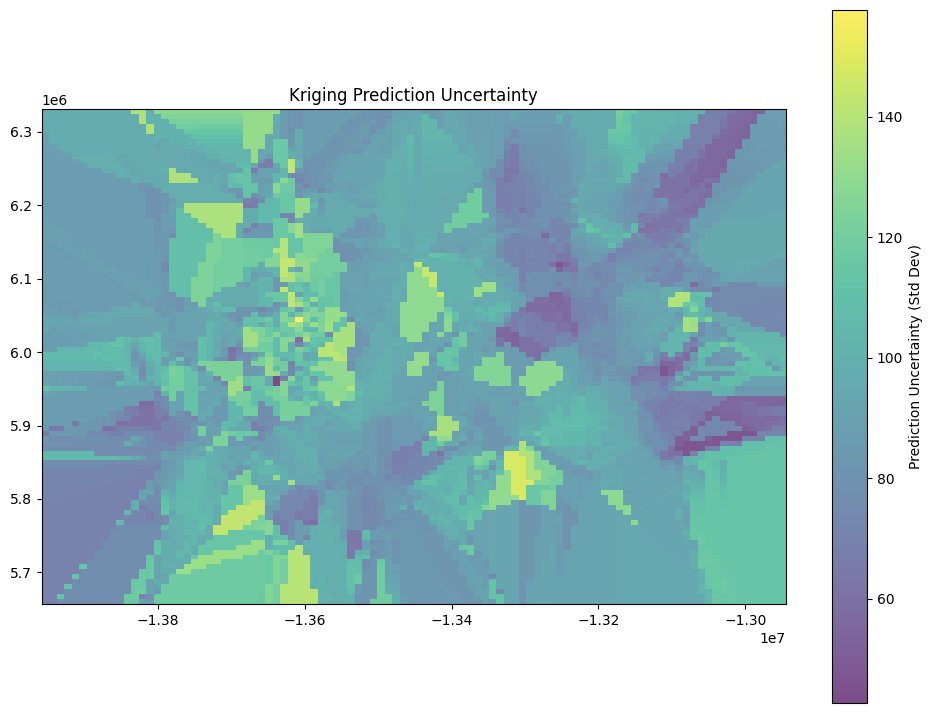

In [ ]:
# Reshape the results to match the grid shape
z_range_grid = z_range.reshape(xx.shape)
z_uncertainty_grid = z_uncertainty.reshape(xx.shape)

# Visualize the interpolated surface
fig, ax = plt.subplots(figsize=(12, 9))
im = ax.imshow(
    z_range_grid,
    extent=(x_min, x_max, y_min, y_max),
    origin='lower',
    cmap='RdYlBu_r',
    alpha=0.7
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs, alpha=1)
cbar = fig.colorbar(im, ax=ax, label='Electric Range (miles)')
ax.set_title('Kriging Interpolation of Electric Vehicle Range')
plt.show()

# Visualize the uncertainty
fig, ax = plt.subplots(figsize=(12, 9))
im = ax.imshow(
    z_uncertainty_grid,
    extent=(x_min, x_max, y_min, y_max),
    origin='lower',
    cmap='viridis',
    alpha=0.7
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs, alpha=1)
cbar = fig.colorbar(im, ax=ax, label='Prediction Uncertainty (Std Dev)')
ax.set_title('Kriging Prediction Uncertainty')
plt.show()


--- Stationarity Assessment ---
Coordinates shape: (39, 2)
EV range values shape: 500
Adjusted to use 39 matching elements

--- Calculating Directional Variograms for Second-Order Stationarity ---

--- Generating Visualizations ---

First-Order Stationarity Assessment of Electric Range by Quadrant:
  Quadrant  Count        Mean    Variance
0       NE      7  132.769358  501.553305
1       NW     11  158.633907  560.492457
2       SW     12  156.011243  336.615784
3       SE      9  153.364296  391.723891
ANOVA F-statistic: 2.22, p-value: 0.1030
Data appears first-order stationary across regions at 5% significance level

Second-Order Stationarity Assessment:
Levene's test for homogeneity of variances: statistic = 0.66, p-value = 0.5824
Data appears second-order stationary (homogeneous variances) based on Levene's test

Directional Variogram Anisotropy Ratio: 3.03
Data appears non-stationary (anisotropic) based on directional variograms


C:\Users\Rohit\AppData\Local\Temp\ipykernel_8824\258020704.py:244: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=labels)



--- Summary of Spatial Analysis ---
1. Analyzed 239176 electric vehicles across Washington state
2. Mean electric range: 153.5 miles
3. Optimal KDE bandwidth (Scott's rule): 13862.39 meters
4. Stationarity analysis:
   - First-order stationarity: Electric range appears stationary across regions
   - Second-order stationarity:
     * Variance homogeneity: Stationary (Levene's test)
     * Directional variograms: Non-stationary (anisotropic)
     * Anisotropy ratio: 3.03
5. Variogram analysis: Maximum lag distance = 280.96 meters with 15 lag bins

Electric Range Statistics by Vehicle Type:
                    Electric Vehicle Type   count       mean        std
0          Battery Electric Vehicle (BEV)  189674  49.264311  93.021611
1  Plug-in Hybrid Electric Vehicle (PHEV)   49502  31.313119  14.544828


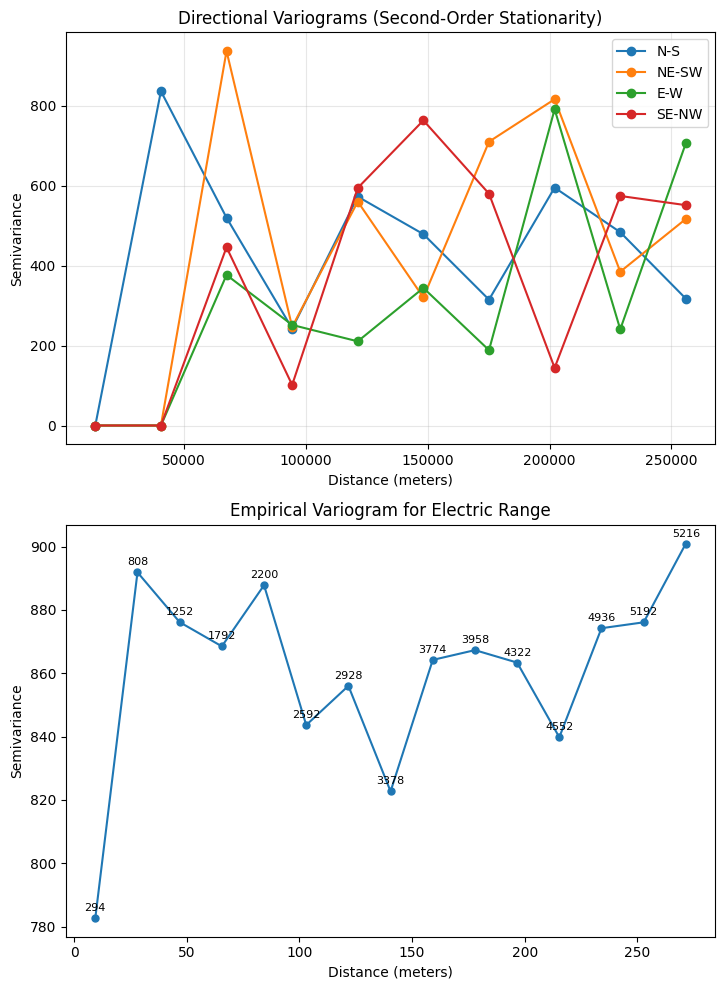

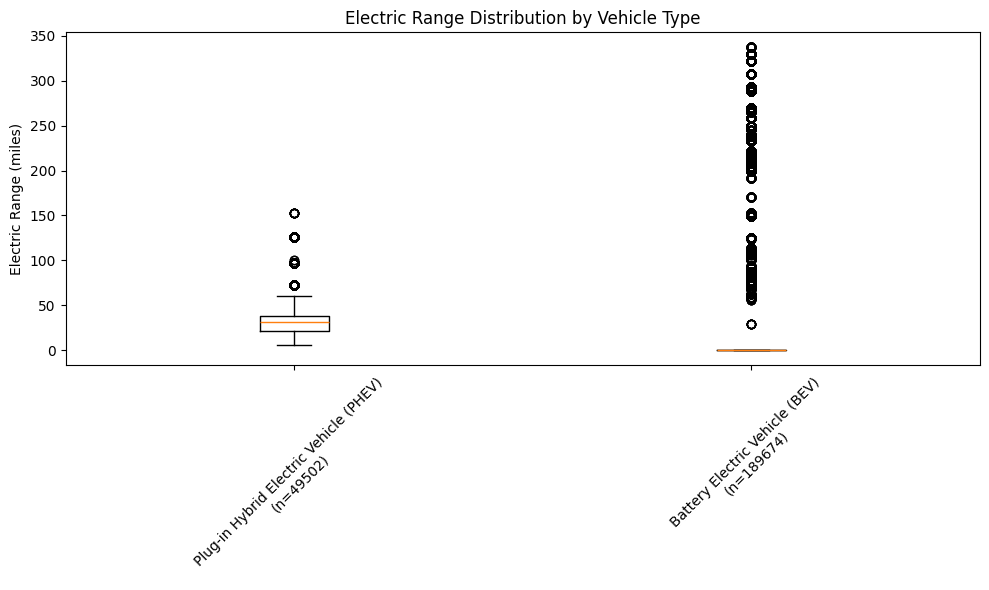

In [107]:
from scipy.stats import f_oneway, levene
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import pdist, squareform

# 4. Stationarity Assessment
print("\n--- Stationarity Assessment ---")

# Divide the region into quadrants and calculate statistics in each
def check_stationarity(coords, values):
    # Make sure coords and values have the same length
    if len(coords) != len(values):
        print(f"Warning: Length mismatch - coords: {len(coords)}, values: {len(values)}")
        # If they don't match, we need to ensure we're using the same subset
        # If coords is a subset, we'll use the same indices for values
        min_len = min(len(coords), len(values))
        coords = coords[:min_len]
        values = values[:min_len]
        print(f"Using first {min_len} elements from both arrays")
    
    x_mid = (coords[:, 0].min() + coords[:, 0].max()) / 2
    y_mid = (coords[:, 1].min() + coords[:, 1].max()) / 2
    
    # Define quadrants
    q1_mask = (coords[:, 0] >= x_mid) & (coords[:, 1] >= y_mid)
    q2_mask = (coords[:, 0] < x_mid) & (coords[:, 1] >= y_mid)
    q3_mask = (coords[:, 0] < x_mid) & (coords[:, 1] < y_mid)
    q4_mask = (coords[:, 0] >= x_mid) & (coords[:, 1] < y_mid)
    
    # Calculate statistics for each quadrant
    quadrants = {
        'NE': values[q1_mask],
        'NW': values[q2_mask], 
        'SW': values[q3_mask],
        'SE': values[q4_mask]
    }
    
    stats_df = pd.DataFrame({
        'Quadrant': list(quadrants.keys()),
        'Count': [len(v) for v in quadrants.values()],
        'Mean': [np.mean(v) if len(v) > 0 else np.nan for v in quadrants.values()],
        'Variance': [np.var(v) if len(v) > 0 else np.nan for v in quadrants.values()]
    })
    
    # Check for significant differences in means using ANOVA - only use quadrants with data
    valid_quadrants = [quadrants[q] for q in quadrants if len(quadrants[q]) > 0]
    
    if len(valid_quadrants) > 1:  # Need at least 2 groups for ANOVA
        f_stat, p_value = f_oneway(*valid_quadrants)
    else:
        print("Warning: Not enough valid quadrants for ANOVA test")
        f_stat, p_value = np.nan, np.nan
    
    # Check for homogeneity of variances using Levene's test (for second-order stationarity)
    if len(valid_quadrants) > 1:
        levene_stat, levene_p = levene(*valid_quadrants)
    else:
        print("Warning: Not enough valid quadrants for Levene's test")
        levene_stat, levene_p = np.nan, np.nan
    
    return stats_df, f_stat, p_value, levene_stat, levene_p

# Function to check for second-order stationarity using directional variograms
def check_second_order_stationarity(coords, values, n_dirs=4, n_lags=10):
    # Create distance matrix
    dist_matrix = squareform(pdist(coords))
    
    # Define directional sectors (in radians) - N, NE, E, SE
    angle_sector_size = np.pi / n_dirs
    
    # Calculate angles between all pairs of points
    angles = np.zeros_like(dist_matrix)
    for i in range(len(coords)):
        for j in range(i+1, len(coords)):
            # Calculate angle: arctan2(y2-y1, x2-x1)
            angle = np.arctan2(coords[j, 1] - coords[i, 1], 
                              coords[j, 0] - coords[i, 0])
            # Make sure angle is positive [0, 2π]
            if angle < 0:
                angle += 2 * np.pi
            angles[i, j] = angle
            angles[j, i] = angle  # symmetric
    
    # Maximum lag distance - use 1/3 of the max distance for reliable estimates
    max_dist = np.max(dist_matrix) / 3
    lag_size = max_dist / n_lags
    
    # Initialize storage for directional variograms
    dir_variograms = []
    directions = []
    
    # Calculate variogram for each direction
    for d in range(n_dirs):
        # Define direction angle range
        center_angle = d * angle_sector_size + angle_sector_size / 2
        direction_name = ['N-S', 'NE-SW', 'E-W', 'SE-NW'][d]
        directions.append(direction_name)
        
        # Get pairs in this direction (within tolerance)
        angle_min = d * angle_sector_size
        angle_max = (d + 1) * angle_sector_size
        
        # Storage for this direction's variogram
        dir_variogram = np.zeros(n_lags)
        dir_pair_counts = np.zeros(n_lags)
        
        # Process each lag bin
        for lag in range(n_lags):
            lag_min = lag * lag_size
            lag_max = (lag + 1) * lag_size
            
            pairs_in_bin = []
            
            # Find all point pairs in this lag and direction
            for i in range(len(coords)):
                for j in range(i+1, len(coords)):
                    dist = dist_matrix[i, j]
                    angle = angles[i, j]
                    
                    # Check if within lag bin
                    if lag_min <= dist < lag_max:
                        # Check if in direction sector or opposite sector (180° apart)
                        in_sector = (angle_min <= angle < angle_max) or \
                                    (angle_min + np.pi <= angle < angle_max + np.pi) or \
                                    (angle_min - np.pi <= angle < angle_max - np.pi)
                        
                        if in_sector:
                            # Calculate squared difference for variogram
                            sq_diff = (values[i] - values[j])**2
                            pairs_in_bin.append(sq_diff)
            
            # Calculate variogram value if pairs exist
            if pairs_in_bin:
                dir_variogram[lag] = np.mean(pairs_in_bin) / 2
                dir_pair_counts[lag] = len(pairs_in_bin)
        
        dir_variograms.append(dir_variogram)
    
    # Calculate lag centers for plotting
    lag_centers = np.arange(n_lags) * lag_size + lag_size / 2
    
    # Calculate variogram anisotropy ratio as a measure of non-stationarity
    variogram_values = np.array(dir_variograms)
    # Filter out lags with insufficient data
    valid_lags = np.all(variogram_values > 0, axis=0)
    
    if np.any(valid_lags):
        valid_variograms = variogram_values[:, valid_lags]
        anisotropy_ratios = np.max(valid_variograms, axis=0) / np.min(valid_variograms, axis=0)
        avg_anisotropy = np.mean(anisotropy_ratios)
    else:
        avg_anisotropy = np.nan
    
    return dir_variograms, directions, lag_centers, avg_anisotropy

# Before running the stationarity check, verify the arrays
print(f"Coordinates shape: {coords.shape}")
print(f"EV range values shape: {len(ev_range)}")

# Make sure coords and ev_range have matching sizes before checking stationarity
# This ensures we're using the same subset of data for both
if isinstance(coords, np.ndarray) and len(coords) != len(ev_range):
    min_len = min(len(coords), len(ev_range))
    adjusted_coords = coords[:min_len]
    adjusted_ev_range = ev_range[:min_len]
    print(f"Adjusted to use {min_len} matching elements")
else:
    adjusted_coords = coords
    adjusted_ev_range = ev_range

# Check first-order stationarity for electric range
stationarity_stats, f_stat, p_value, levene_stat, levene_p = check_stationarity(adjusted_coords, adjusted_ev_range)
is_1st_order_stationary = p_value > 0.05 if not np.isnan(p_value) else None  # Using 5% significance level
is_2nd_order_stationary_levene = levene_p > 0.05 if not np.isnan(levene_p) else None  # Using 5% significance level

# Calculate directional variograms for second-order stationarity assessment
print("\n--- Calculating Directional Variograms for Second-Order Stationarity ---")
dir_variograms, directions, lag_centers_dir, anisotropy_ratio = check_second_order_stationarity(
    adjusted_coords, adjusted_ev_range, n_dirs=4, n_lags=10
)

# Second-order stationarity assessment based on directional variograms
is_2nd_order_stationary_variogram = anisotropy_ratio < 2.0 if not np.isnan(anisotropy_ratio) else None

# 5. Visualize Results
print("\n--- Generating Visualizations ---")

plt.figure(figsize=(14, 10))

# 5.1 Original variogram plot (bottom right)
plt.subplot(224)
plt.plot(lag_centers, variogram, 'o-', markersize=5)
plt.title('Empirical Variogram for Electric Range')
plt.xlabel('Distance (meters)')
plt.ylabel('Semivariance')
for i, (x, y, count) in enumerate(zip(lag_centers, variogram, pair_counts)):
    plt.annotate(f"{count:.0f}", (x, y), textcoords="offset points", 
                 xytext=(0,5), ha='center', fontsize=8)

# 5.2 Add a new plot for directional variograms (top right)
plt.subplot(222)
for i, (dir_variogram, direction) in enumerate(zip(dir_variograms, directions)):
    plt.plot(lag_centers_dir, dir_variogram, 'o-', label=direction)
plt.title('Directional Variograms (Second-Order Stationarity)')
plt.xlabel('Distance (meters)')
plt.ylabel('Semivariance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ev_spatial_analysis.png', dpi=300, bbox_inches='tight')

# Display stationarity assessment
print("\nFirst-Order Stationarity Assessment of Electric Range by Quadrant:")
print(stationarity_stats)
if not np.isnan(f_stat) and not np.isnan(p_value):
    print(f"ANOVA F-statistic: {f_stat:.2f}, p-value: {p_value:.4f}")
    print(f"Data appears {'first-order stationary' if is_1st_order_stationary else 'non-stationary'} across regions at 5% significance level")
else:
    print("ANOVA test could not be performed due to insufficient data in quadrants")

print("\nSecond-Order Stationarity Assessment:")
if not np.isnan(levene_stat) and not np.isnan(levene_p):
    print(f"Levene's test for homogeneity of variances: statistic = {levene_stat:.2f}, p-value = {levene_p:.4f}")
    print(f"Data appears {'second-order stationary (homogeneous variances)' if is_2nd_order_stationary_levene else 'non-stationary (heterogeneous variances)'} based on Levene's test")
else:
    print("Levene's test could not be performed due to insufficient data in quadrants")

print(f"\nDirectional Variogram Anisotropy Ratio: {anisotropy_ratio:.2f}")
print(f"Data appears {'second-order stationary (isotropic)' if is_2nd_order_stationary_variogram else 'non-stationary (anisotropic)'} based on directional variograms")

# Additional chart: Electric Range by Vehicle Type
plt.figure(figsize=(10, 6))
box_data = []
labels = []
for ev_type in gdf['Electric Vehicle Type'].unique():
    data = gdf[gdf['Electric Vehicle Type'] == ev_type]['Electric Range']
    if len(data) > 0:
        box_data.append(data)
        labels.append(f"{ev_type}\n(n={len(data)})")

plt.boxplot(box_data, labels=labels)
plt.title('Electric Range Distribution by Vehicle Type')
plt.ylabel('Electric Range (miles)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('ev_range_by_type.png', dpi=300, bbox_inches='tight')

# Print final summary
print("\n--- Summary of Spatial Analysis ---")
print(f"1. Analyzed {len(gdf)} electric vehicles across Washington state")
print(f"2. Mean electric range: {np.mean(ev_range):.1f} miles")
print(f"3. Optimal KDE bandwidth (Scott's rule): {bandwidth_scott:.2f} meters")

# Stationarity summary
print("4. Stationarity analysis:")
if is_1st_order_stationary is not None:
    print(f"   - First-order stationarity: Electric range appears {'stationary' if is_1st_order_stationary else 'non-stationary'} across regions")
else:
    print("   - First-order stationarity: Could not determine due to insufficient data")

if is_2nd_order_stationary_levene is not None or is_2nd_order_stationary_variogram is not None:
    print("   - Second-order stationarity:")
    if is_2nd_order_stationary_levene is not None:
        print(f"     * Variance homogeneity: {'Stationary' if is_2nd_order_stationary_levene else 'Non-stationary'} (Levene's test)")
    if is_2nd_order_stationary_variogram is not None:
        print(f"     * Directional variograms: {'Stationary (isotropic)' if is_2nd_order_stationary_variogram else 'Non-stationary (anisotropic)'}")
        print(f"     * Anisotropy ratio: {anisotropy_ratio:.2f}")
else:
    print("   - Second-order stationarity: Could not determine due to insufficient data")

print(f"5. Variogram analysis: Maximum lag distance = {max_dist:.2f} meters with {n_lags} lag bins")

# Display electric range statistics by vehicle type
print("\nElectric Range Statistics by Vehicle Type:")
ev_type_stats = gdf.groupby('Electric Vehicle Type')['Electric Range'].agg(['count', 'mean', 'std']).reset_index()
print(ev_type_stats)

# Point to Lattice Conversion

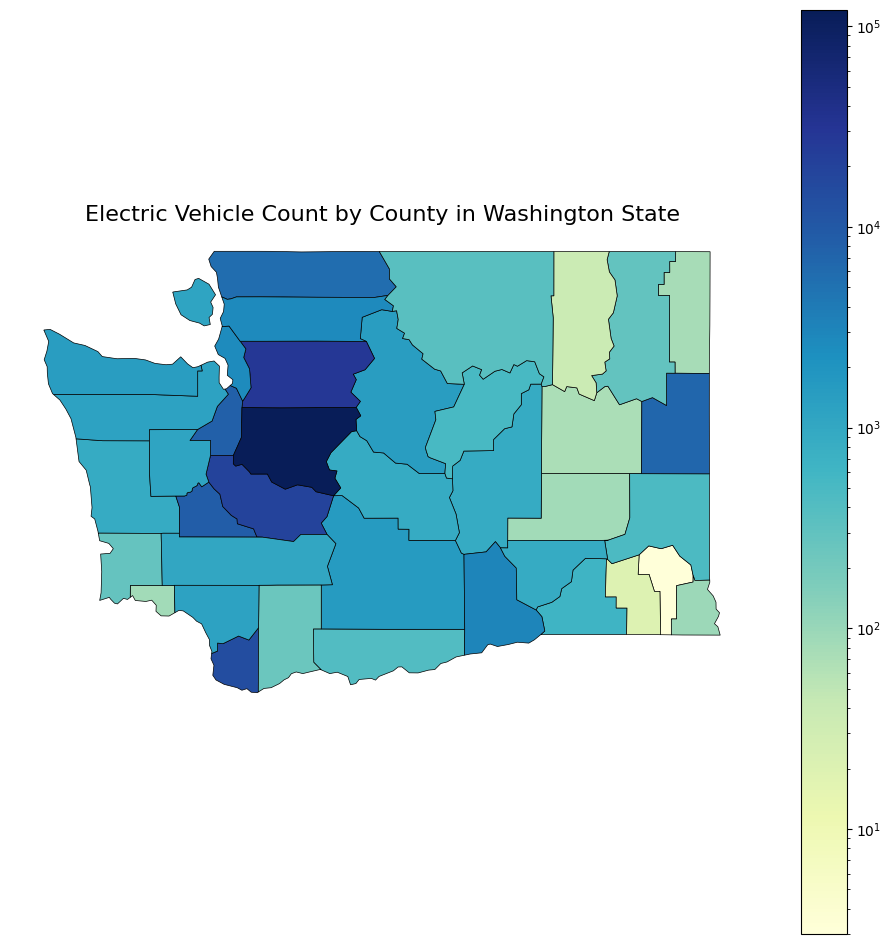

In [13]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Aggregate EV counts by county
gdf_points = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
gdf_points['County'] = gdf_points['County'].str.upper()
county_counts = gdf_points.groupby('County').size().reset_index(name='ev_count')

# Load Washington counties shapefile
shapefile_path = "./cb_2018_us_county_20m.shp"  # Ensure all associated files (.shx, .dbf, etc.) are in same dir
wa_counties = gpd.read_file(shapefile_path)

# Filter to Washington state only (FIPS code 53)
wa_counties = wa_counties[wa_counties['STATEFP'] == '53']
wa_counties['County'] = wa_counties['NAME'].str.upper()

# Merge EV count data with county geometries
wa_ev_lattice = wa_counties.merge(county_counts, on='County', how='left')
wa_ev_lattice['ev_count'] = wa_ev_lattice['ev_count'].fillna(0)

# Plot the lattice map
fig, ax = plt.subplots(figsize=(12, 12))
wa_ev_lattice.plot(
    column='ev_count',
    cmap='YlGnBu',
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    ax=ax,
    norm=LogNorm(vmin=wa_ev_lattice['ev_count'].replace(0, 1).min(), 
                 vmax=wa_ev_lattice['ev_count'].max())
)

ax.set_title("Electric Vehicle Count by County in Washington State", fontsize=16)
ax.axis('off')
plt.show()


In [14]:
from libpysal.weights import Queen, lag_spatial
from esda.moran import Moran, Moran_Local
from esda.geary import Geary
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
import numpy as np

# Ensure geometry is projected (required for distance-based measures)
wa_ev_lattice = wa_ev_lattice.to_crs(epsg=3857)

# Create Queen contiguity weights
w = Queen.from_dataframe(wa_ev_lattice)
w.transform = 'r'

# Attribute vector
y = wa_ev_lattice['ev_count'].values
import numpy as np

# Assuming y is your array of values
y_dB = 10 * np.log10(y)

('WARNING: ', 27, ' is an island (no neighbors)')


C:\Users\Rohit\AppData\Local\Temp\ipykernel_30728\4052079115.py:12: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(wa_ev_lattice)
c:\Users\Rohit\miniconda3\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 27.
  W.__init__(self, neighbors, ids=ids, **kw)


In [15]:
# moran = Moran(y, w)
# print("Moran's I:", moran.I)
# print("p-value:", moran.p_norm)
moran = Moran(y_dB, w)
print("Moran's I:", moran.I)
print("p-value:", moran.p_norm)

Moran's I: 0.4034414258160561
p-value: 6.210656704635962e-05


In [16]:
# geary = Geary(y, w)
# print("Geary's C:", geary.C)
# print("p-value:", geary.p_norm)
geary = Geary(y_dB, w)
print("Geary's C:", geary.C)
print("p-value:", geary.p_norm)

Geary's C: 0.5505204865385357
p-value: 0.00010331409691788872


c:\Users\Rohit\miniconda3\Lib\site-packages\esda\moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


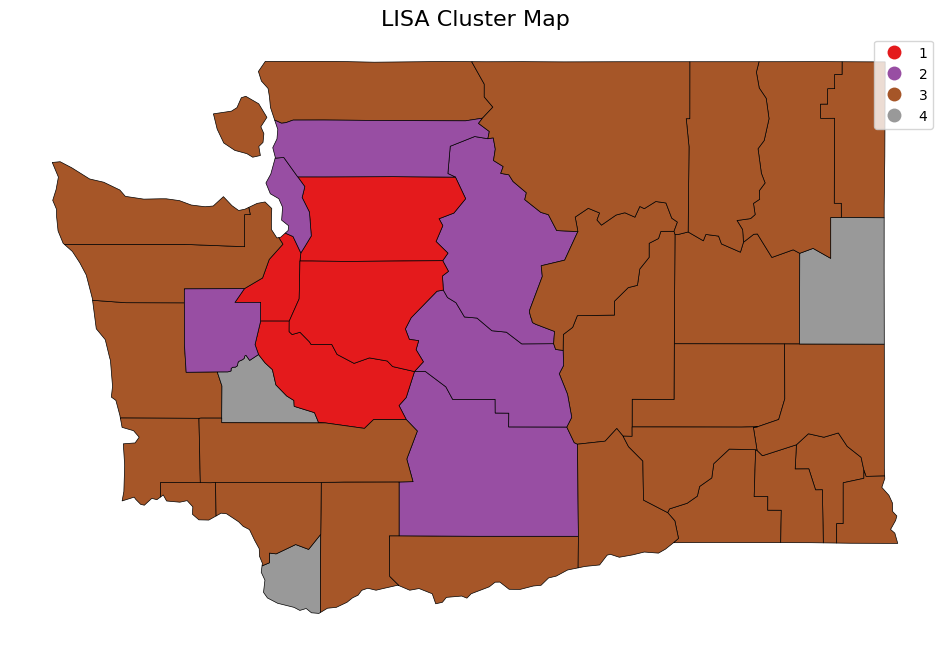

In [17]:
lisa = Moran_Local(y, w)
wa_ev_lattice['local_I'] = lisa.Is
wa_ev_lattice['local_p'] = lisa.p_sim

# Plotting LISA clusters
fig, ax = plt.subplots(figsize=(12, 12))
wa_ev_lattice.assign(
    cl=lisa.q
).plot(
    column='cl', categorical=True,
    k=4, cmap='Set1', linewidth=0.5,
    edgecolor='black', legend=True, ax=ax
)
ax.set_title("LISA Cluster Map", fontsize=16)
ax.axis('off')
plt.show()

Global Moran's I: 0.40341418403725204
p-value: 0.001


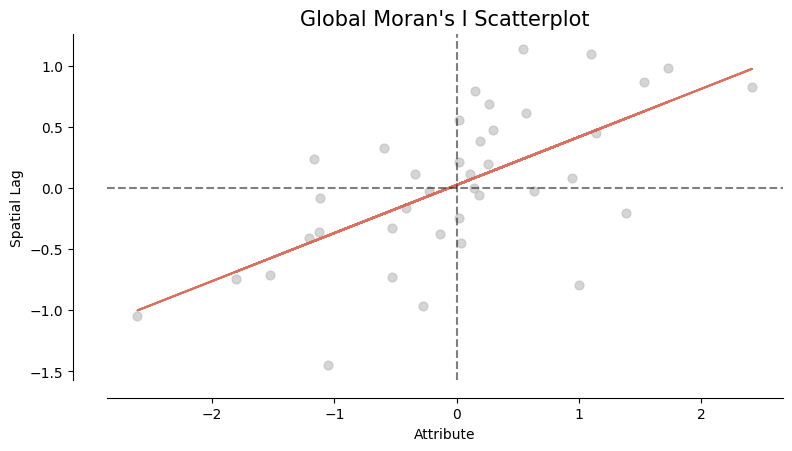

In [22]:
from esda.moran import Moran
from splot.esda import moran_scatterplot

# Global Moran's I
y_adj = np.log1p(wa_ev_lattice['ev_count'].values)  # log(1+x) to handle zeros
global_moran = Moran(y_adj, w)

# Print results
print("Global Moran's I:", global_moran.I)
print("p-value:", global_moran.p_sim)

# Plot Moran's I scatterplot
fig, ax = plt.subplots(figsize=(8, 8))
moran_scatterplot(global_moran, ax=ax)
ax.set_title("Global Moran's I Scatterplot", fontsize=15)
plt.tight_layout()
plt.savefig('global_moran_scatterplot.png', dpi=300)
plt.show()

Calculating Getis-Ord G* statistic...


c:\Users\Rohit\miniconda3\Lib\site-packages\esda\getisord.py:527: RuntimeWarning: invalid value encountered in divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)
c:\Users\Rohit\miniconda3\Lib\site-packages\esda\getisord.py:450: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim
c:\Users\Rohit\miniconda3\Lib\site-packages\esda\moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


Calculating Local Moran's I...

Significant Local Moran's I values (p < 0.05):
       County  ev_count   local_I  local_p  quad
1    GARFIELD         3  2.654376    0.021     2
15  SNOHOMISH     29428  1.645296    0.008     1
19     KITSAP      8070  1.168902    0.001     1
20    WHITMAN       477  0.263018    0.005     2
21     ASOTIN        97  1.479423    0.018     2
23     PIERCE     19672  1.294005    0.003     1
25       KING    120354  1.935959    0.003     1
26     ISLAND      2586  0.598564    0.023     1
27   SAN JUAN      1140  0.000000    0.001     0
32      MASON      1159  0.118138    0.032     1

Significant Getis-Ord G* values (p < 0.05):
       County  ev_count    g_star  g_star_p
1    GARFIELD         3  0.017583     0.013
14     CHELAN      1461  0.031844     0.034
15  SNOHOMISH     29428  0.034628     0.006
18   COLUMBIA        20  0.020038     0.040
19     KITSAP      8070  0.035387     0.001
20    WHITMAN       477  0.018534     0.003
21     ASOTIN        97  0.01

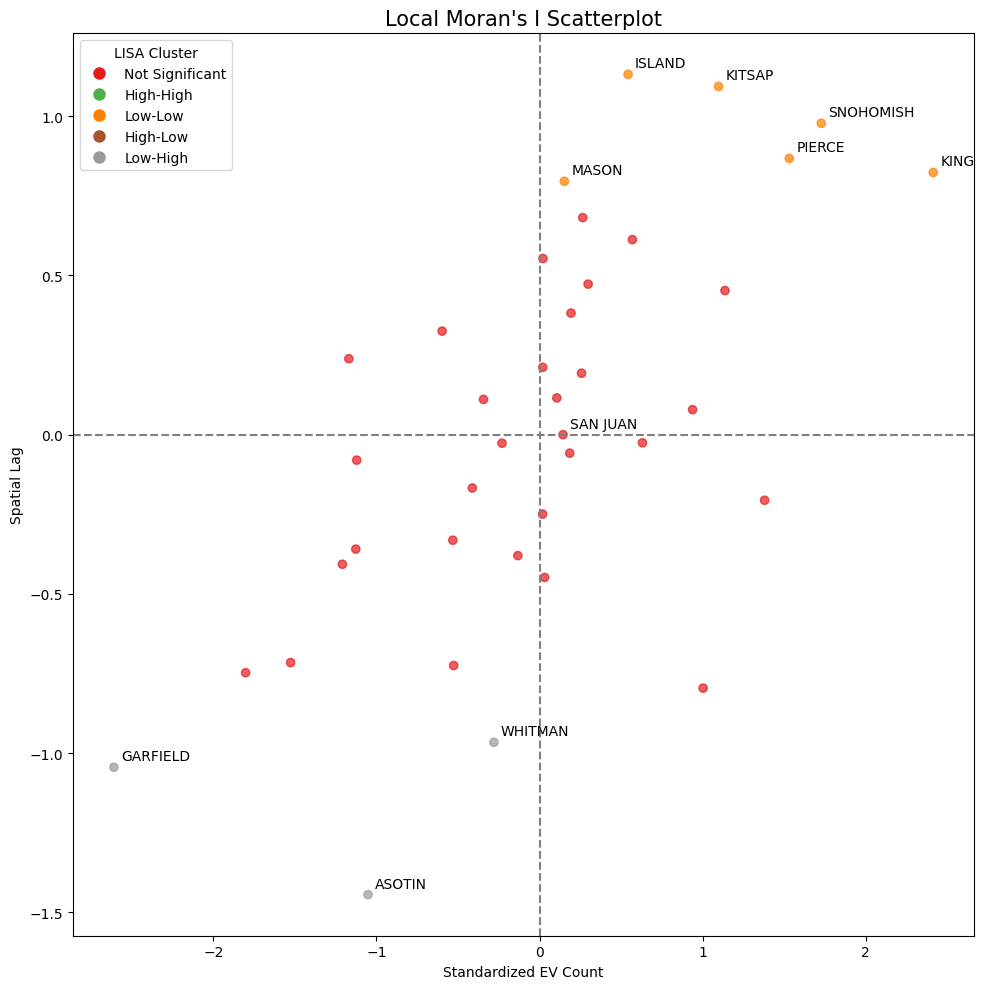

c:\Users\Rohit\miniconda3\Lib\site-packages\geopandas\plotting.py:946: UserWarning: Mismatched number of handles and labels: len(handles) = 3 len(labels) = 5
  ax.legend(**legend_kwds)


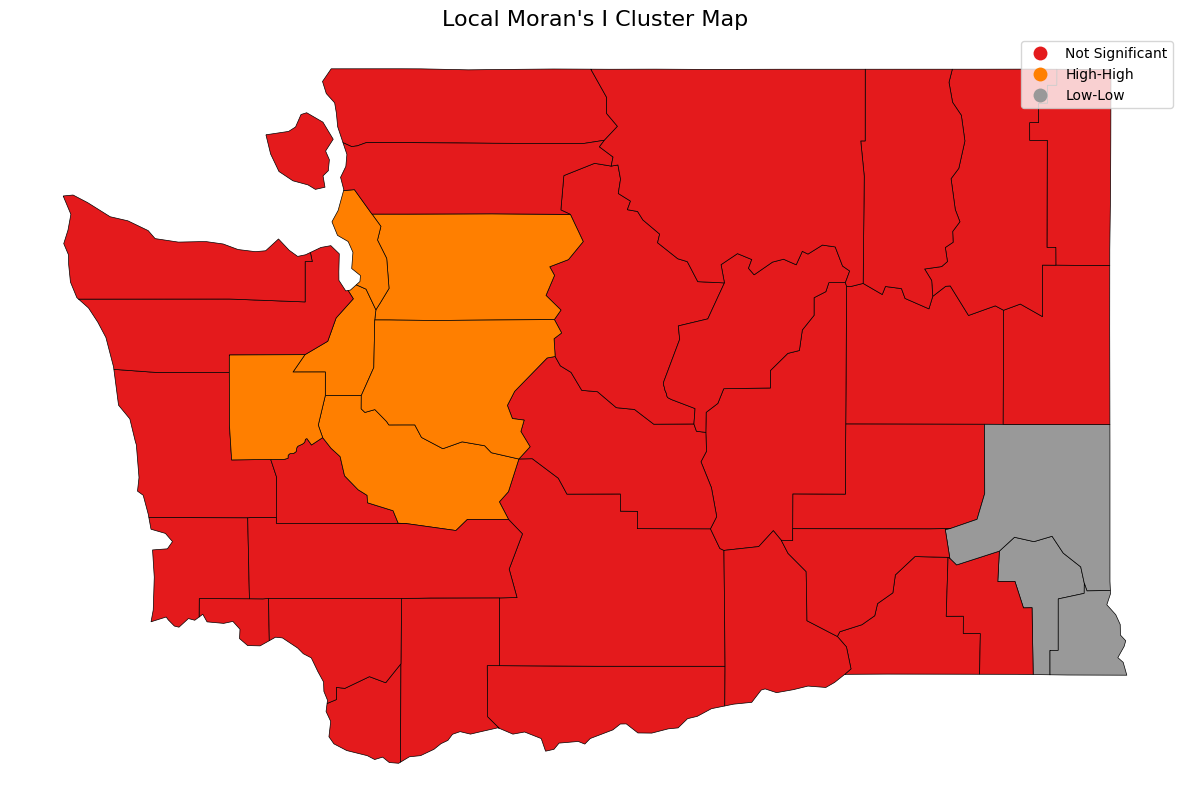

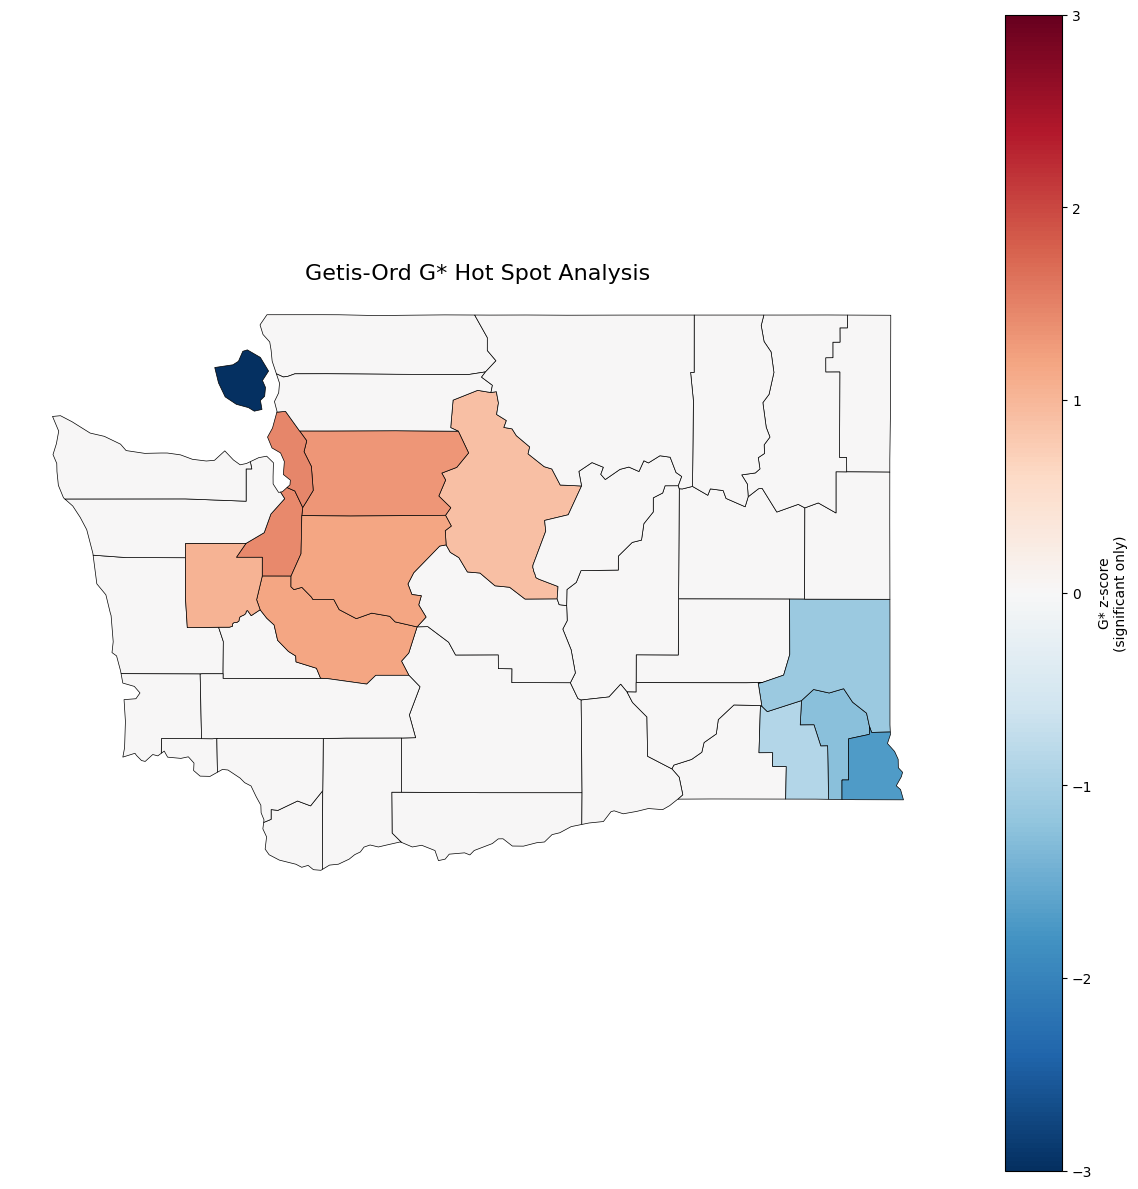

c:\Users\Rohit\miniconda3\Lib\site-packages\geopandas\plotting.py:946: UserWarning: Mismatched number of handles and labels: len(handles) = 3 len(labels) = 5
  ax.legend(**legend_kwds)


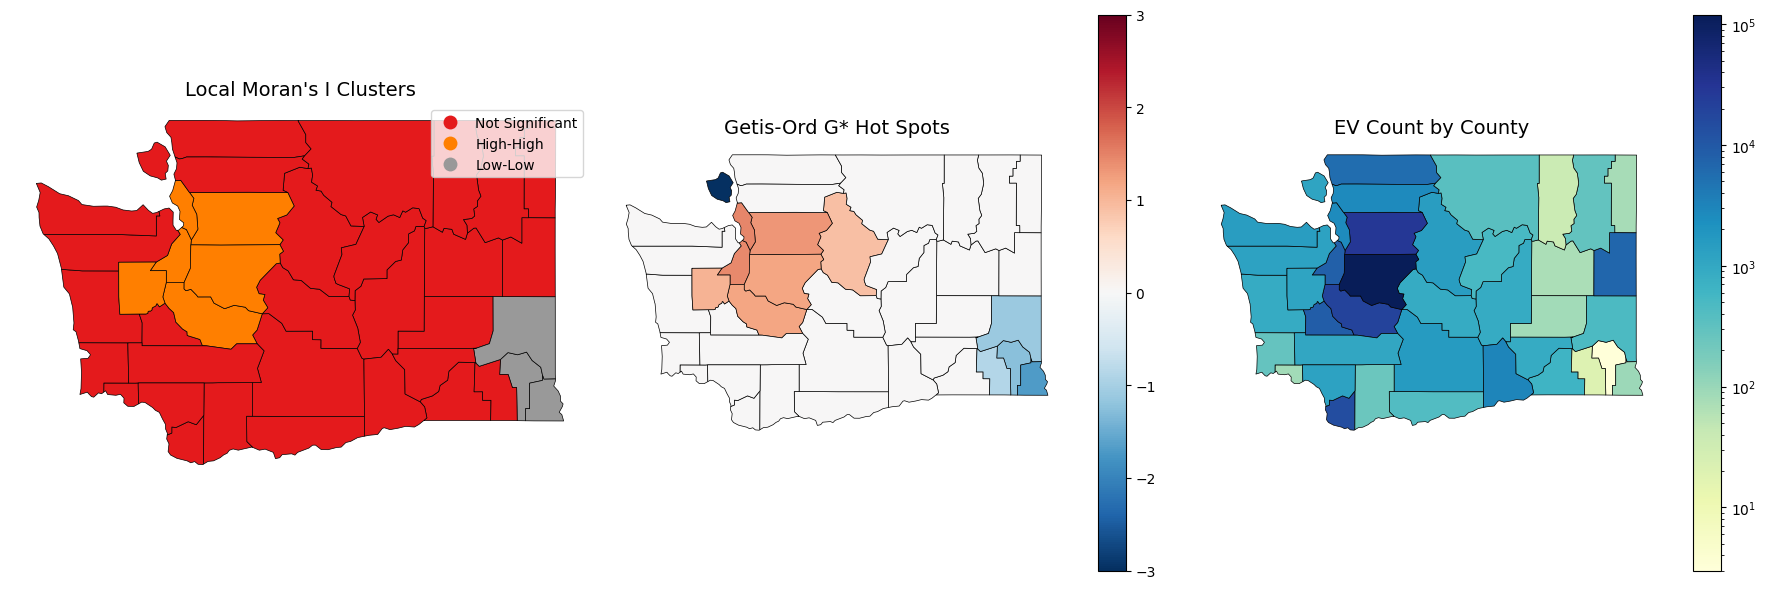

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from libpysal.weights import Queen
from esda.moran import Moran_Local
from esda.getisord import G_Local
import matplotlib.colors as colors
import seaborn as sns

# Assuming wa_ev_lattice and w are already defined from your code
# Make sure our weight matrix is properly row-standardized
w.transform = 'r'

# Apply log transformation to handle zeros (add small constant)
y_adj = np.log1p(wa_ev_lattice['ev_count'].values)  # log(1+x) to handle zeros

# 1. Getis-Ord G* statistic
print("Calculating Getis-Ord G* statistic...")
g_local = G_Local(y_adj, w)

# Add results to the GeoDataFrame
wa_ev_lattice['g_star'] = g_local.Gs
wa_ev_lattice['g_star_p'] = g_local.p_sim

# 2. Calculate Local Moran's I
print("Calculating Local Moran's I...")
lisa = Moran_Local(y_adj, w)
wa_ev_lattice['local_I'] = lisa.Is
wa_ev_lattice['local_p'] = lisa.p_sim

# 3. Manual calculation for Local Moran's I quadrants
# Standardize variable
z = (y_adj - y_adj.mean()) / y_adj.std()
# Calculate spatial lags
lag_z = np.zeros(len(z))
for i, neigh in w.neighbors.items():
    if len(neigh) > 0:
        weights = np.array([w.weights[i][neigh.index(j)] for j in neigh])
        vals = np.array([z[j] for j in neigh])
        lag_z[i] = np.sum(weights * vals) / np.sum(weights)

# Classify quadrants: 1=HH, 2=LL, 3=HL, 4=LH
wa_ev_lattice['quad'] = 0  # Default: not significant
sig_idx = wa_ev_lattice['local_p'] < 0.05
wa_ev_lattice.loc[sig_idx & (z > 0) & (lag_z > 0), 'quad'] = 1  # High-High (hot spots)
wa_ev_lattice.loc[sig_idx & (z < 0) & (lag_z < 0), 'quad'] = 2  # Low-Low (cold spots)
wa_ev_lattice.loc[sig_idx & (z > 0) & (lag_z < 0), 'quad'] = 3  # High-Low (spatial outliers)
wa_ev_lattice.loc[sig_idx & (z < 0) & (lag_z > 0), 'quad'] = 4  # Low-High (spatial outliers)

# Print significant clusters
print("\nSignificant Local Moran's I values (p < 0.05):")
sig_lisa = wa_ev_lattice[wa_ev_lattice['local_p'] < 0.05][['County', 'ev_count', 'local_I', 'local_p', 'quad']]
print(sig_lisa)

print("\nSignificant Getis-Ord G* values (p < 0.05):")
sig_g = wa_ev_lattice[wa_ev_lattice['g_star_p'] < 0.05][['County', 'ev_count', 'g_star', 'g_star_p']]
print(sig_g)

# 4. Create plots
# 4.1 Plot Local Moran's I Scatterplot
fig, ax = plt.subplots(figsize=(10, 10))

# Create scatter plot
scatter = ax.scatter(z, lag_z, c=wa_ev_lattice['quad'], cmap='Set1', alpha=0.7)

# Add lines
ax.axvline(0, color='gray', linestyle='--')
ax.axhline(0, color='gray', linestyle='--')

# Customize plot
ax.set_xlabel('Standardized EV Count')
ax.set_ylabel('Spatial Lag')
ax.set_title("Local Moran's I Scatterplot", fontsize=15)

# Label significant points
sig_idx = np.where(wa_ev_lattice['local_p'] < 0.05)[0]
for idx in sig_idx:
    ax.annotate(wa_ev_lattice.iloc[idx]['County'], 
                (z[idx], lag_z[idx]),
                xytext=(5, 5), textcoords='offset points')

# Add legend
legend_labels = {0: 'Not Significant', 1: 'High-High', 2: 'Low-Low', 3: 'High-Low', 4: 'Low-High'}
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.Set1(i/4), markersize=10) 
           for i in range(5)]
ax.legend(handles, [legend_labels[i] for i in range(5)], title='LISA Cluster', loc='best')

plt.tight_layout()
plt.savefig('moran_scatterplot.png', dpi=300)
plt.show()

# 4.2 Plot Local Moran's I cluster map
fig, ax = plt.subplots(figsize=(12, 12))

# Create a categorical plot
wa_ev_lattice.plot(
    column='quad',
    categorical=True,
    k=5,
    cmap='Set1',
    linewidth=0.5,
    edgecolor='black',
    ax=ax,
    legend=True,
    legend_kwds={'labels': ['Not Significant', 'High-High', 'Low-Low', 'High-Low', 'Low-High']}
)

ax.set_title("Local Moran's I Cluster Map", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.savefig('lisa_clusters.png', dpi=300)
plt.show()

# 4.3 Plot Getis-Ord G* hot spot map
fig, ax = plt.subplots(figsize=(12, 12))

# Define custom colormap for hot and cold spots
cmap = plt.cm.RdBu_r
vmin = -3
vmax = 3
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# Calculate z-scores for visualization
wa_ev_lattice['g_z'] = (wa_ev_lattice['g_star'] - g_local.Gs.mean()) / g_local.Gs.std()

# Only show significant clusters
wa_ev_lattice['g_z_sig'] = wa_ev_lattice['g_z']
wa_ev_lattice.loc[wa_ev_lattice['g_star_p'] >= 0.05, 'g_z_sig'] = 0

wa_ev_lattice.plot(
    column='g_z_sig',
    cmap=cmap,
    linewidth=0.5,
    edgecolor='black',
    ax=ax,
    norm=norm,
    legend=True,
    legend_kwds={'label': "G* z-score\n(significant only)"}
)
ax.set_title("Getis-Ord G* Hot Spot Analysis", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.savefig('getis_ord_hotspots.png', dpi=300)
plt.show()

# 4.4 Combined analysis summary map
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# LISA Clusters
wa_ev_lattice.plot(
    column='quad',
    categorical=True,
    k=5,
    cmap='Set1',
    linewidth=0.5,
    edgecolor='black',
    ax=axs[0],
    legend=True,
    legend_kwds={'labels': ['Not Significant', 'High-High', 'Low-Low', 'High-Low', 'Low-High']}
)
axs[0].set_title("Local Moran's I Clusters", fontsize=14)
axs[0].axis('off')

# Getis-Ord G*
wa_ev_lattice.plot(
    column='g_z_sig',
    cmap=cmap,
    linewidth=0.5,
    edgecolor='black',
    ax=axs[1],
    norm=norm,
    legend=True
)
axs[1].set_title("Getis-Ord G* Hot Spots", fontsize=14)
axs[1].axis('off')

# Original Data
wa_ev_lattice.plot(
    column='ev_count',
    cmap='YlGnBu',
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    ax=axs[2],
    norm=colors.LogNorm(vmin=wa_ev_lattice['ev_count'].replace(0, 1).min(),
                       vmax=wa_ev_lattice['ev_count'].max())
)
axs[2].set_title("EV Count by County", fontsize=14)
axs[2].axis('off')

plt.tight_layout()
plt.savefig('spatial_analysis_summary.png', dpi=300)
plt.show()

('WARNING: ', 27, ' is an island (no neighbors)')
('WARNING: ', 27, ' is an island (no neighbors)')
('WARNING: ', 27, ' is an island (no neighbors)')
('WARNING: ', 27, ' is an island (no neighbors)')
('WARNING: ', 7, ' is an island (no neighbors)')
('WARNING: ', 13, ' is an island (no neighbors)')
('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 27, ' is an island (no neighbors)')


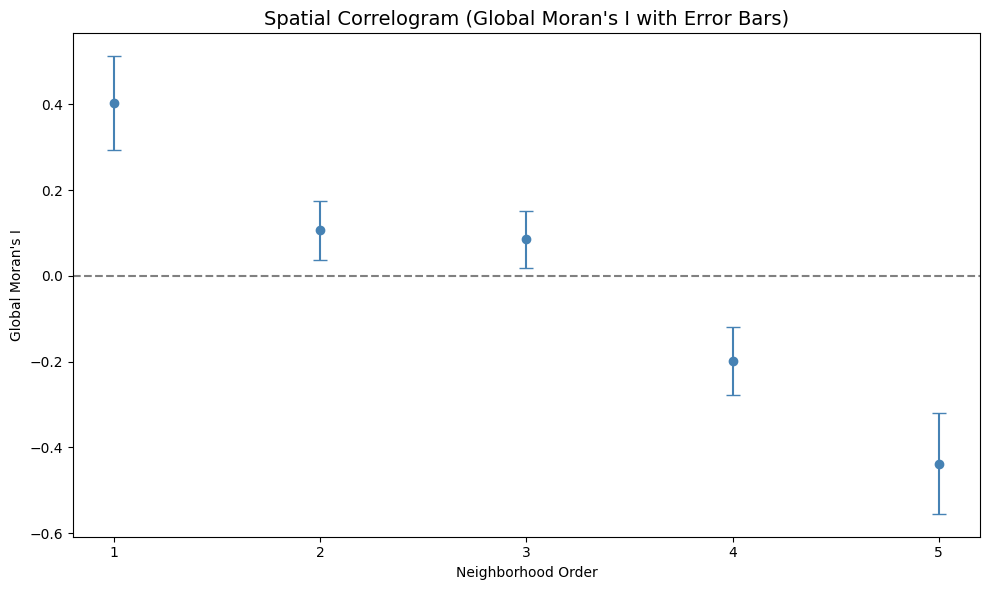

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from libpysal.weights import Queen
from libpysal.weights.util import full2W
from esda.moran import Moran

# Assume you already have a valid Queen weights object `w` and adjusted variable `y_adj`

W_matrix = w.full()[0]
W_matrix[W_matrix != 0] = 1  # Make binary

id_order = w.id_order
n = W_matrix.shape[0]
max_order = 5

moran_values = []
moran_pvalues = []
moran_std = []  # Standard deviations for error bars

for order in range(1, max_order + 1):
    A_k = np.linalg.matrix_power(W_matrix, order)
    A_k[A_k != 0] = 1  # Binarize
    
    # Remove lower-order connections
    for prev_order in range(1, order):
        A_prev = np.linalg.matrix_power(W_matrix, prev_order)
        A_k[A_prev != 0] = 0

    np.fill_diagonal(A_k, 0)

    w_k = full2W(A_k, ids=id_order)
    w_k.transform = 'r'

    moran = Moran(y_adj, w_k)
    moran_values.append(moran.I)
    moran_pvalues.append(moran.p_sim)
    moran_std.append(np.std(moran.sim))  # Error bars from permutations

# Plot with error bars
orders = np.arange(1, max_order + 1)

fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(orders, moran_values, yerr=moran_std, fmt='o', capsize=5, color='steelblue')
ax.axhline(0, color='gray', linestyle='--')
ax.set_title("Spatial Correlogram (Global Moran's I with Error Bars)", fontsize=14)
ax.set_xlabel("Neighborhood Order")
ax.set_ylabel("Global Moran's I")
plt.xticks(orders)
plt.tight_layout()
plt.savefig('spatial_correlogram_with_errorbars.png', dpi=300)
plt.show()

In [21]:
# Attribute distances
attr_dist = squareform(pdist(y.reshape(-1, 1), metric='euclidean'))

# Spatial distances from centroids
coords = np.array(list(wa_ev_lattice.centroid.apply(lambda x: (x.x, x.y))))
spatial_dist = squareform(pdist(coords, metric='euclidean'))

# Mantel Test (Pearson correlation between distance matrices)
mantel_r, mantel_p = pearsonr(attr_dist[np.triu_indices_from(attr_dist, 1)],
                              spatial_dist[np.triu_indices_from(spatial_dist, 1)])
mantel_r = np.abs(mantel_r)
print("Mantel r:", mantel_r)
print("Mantel p-value:", mantel_p)

Mantel r: 0.11225982840745184
Mantel p-value: 0.0022105638999469586


# Spatial Data Mining

Shape of coordinates: (239176, 2)
Shape of y values: (239176,)

Working with 239176 data points after consistency check
1. EXPLORATORY SPATIAL DATA ANALYSIS

Basic statistics of Electric Range:
count    239176.000000
mean         45.548972
std          83.419312
min           0.000000
25%           0.000000
50%           0.000000
75%          38.000000
max         337.000000
dtype: float64


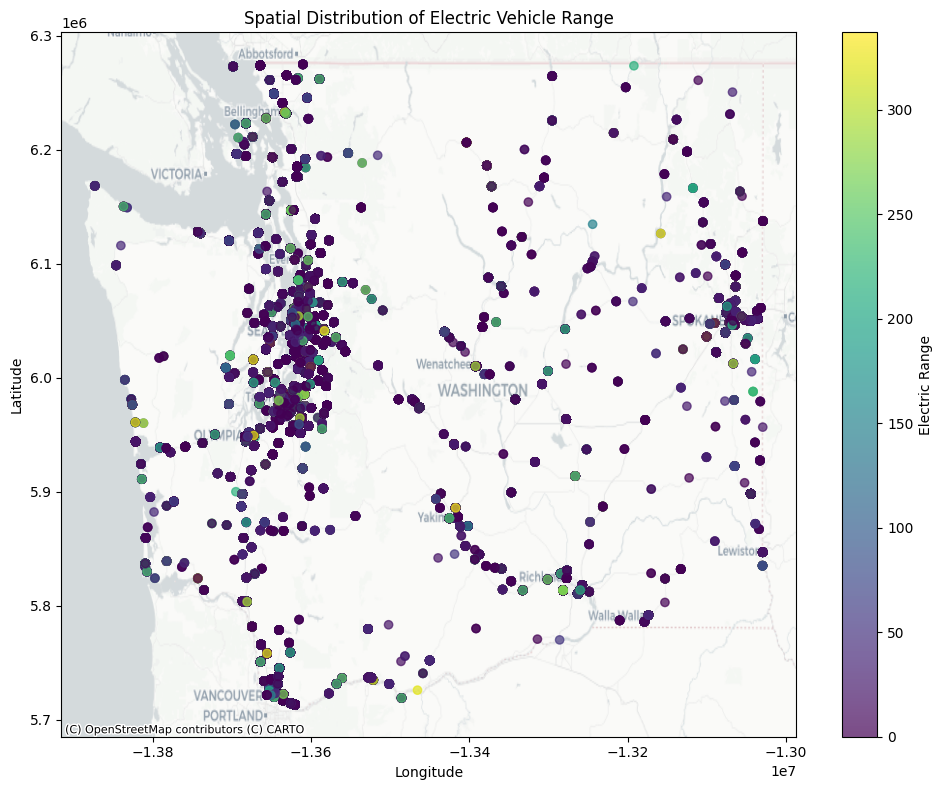


Spatial distribution plot saved as 'point_distribution.png'


In [13]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import DBSCAN
from scipy.spatial import distance
import statsmodels.api as sm
from pysal.explore import esda
from pysal.lib import weights
from sklearn.neighbors import NearestNeighbors
import numpy.ma as ma
import matplotlib.colors as colors
import warnings
import contextily as ctx
warnings.filterwarnings('ignore')

# Function to ensure consistent data dimensions
def check_data_consistency(coords, y, label="Electric Range"):
    """
    Ensure that coordinates and values arrays have matching dimensions
    """
    # Check if coords and y have the same number of elements
    if len(coords) != len(y):
        print(f"WARNING: Dimension mismatch between coordinates ({len(coords)} points) and {label} values ({len(y)} points)")
        
        # Find the minimum length
        min_length = min(len(coords), len(y))
        print(f"Using only the first {min_length} points where both coordinates and values exist")
        
        # Trim both arrays to the same length
        coords = coords[:min_length]
        y = y[:min_length]
        
    return coords, y

# Assuming the data extraction code has already been run:
# df['Longitude'] = df['Vehicle Location'].str.extract(r'POINT \(([^ ]+)')[0].astype(float)
# df['Latitude'] = df['Vehicle Location'].str.extract(r'POINT \([^)]+ ([^)]+)')[0].astype(float)
# df.dropna(subset=['Longitude', 'Latitude'], inplace=True)
# df['geometry'] = df.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
# gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326").to_crs(epsg=3857)
# coords = np.vstack([gdf.geometry.x, gdf.geometry.y]).T
# y = gdf['Electric Range'].values

# We need to make sure coords and y have the same length
# The error suggests a dimension mismatch
print(f"Shape of coordinates: {coords.shape}")
print(f"Shape of y values: {y.shape if hasattr(y, 'shape') else len(y)}")

# Ensure data consistency - this is critical
coords, y = check_data_consistency(coords, y)
n = len(y)

print(f"\nWorking with {n} data points after consistency check")

# 1. EXPLORATORY SPATIAL DATA ANALYSIS
print("=" * 50)
print("1. EXPLORATORY SPATIAL DATA ANALYSIS")
print("=" * 50)

# Basic statistics of the point data
print("\nBasic statistics of Electric Range:")
print(pd.Series(y).describe())

# Plot the point distribution
fig, ax = plt.subplots(figsize=(10, 8))
sc = ax.scatter(coords[:, 0], coords[:, 1], c=y, cmap='viridis', alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs)
plt.colorbar(sc, ax=ax, label='Electric Range')
ax.set_title('Spatial Distribution of Electric Vehicle Range')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.savefig('point_distribution.png')
plt.show()
plt.close()

print("\nSpatial distribution plot saved as 'point_distribution.png'")



2. POINT PATTERN ANALYSIS

Using k=10 neighbors for nearest neighbor analysis

Nearest Neighbor Distance Analysis:
Mean nearest neighbor distance: 2.40
Median nearest neighbor distance: 0.00
Min nearest neighbor distance: 0.00
Max nearest neighbor distance: 44001.34

Point density: 0.0000005045 points per square unit
Average distance threshold (0.5/√density): 703.98

Complete Spatial Randomness Test:
Observed mean distance: 2.40
Expected mean distance under CSR: 703.98
Nearest neighbor ratio (R): 0.0034
R < 1: Points exhibit clustering

Calculating Ripley's K function...


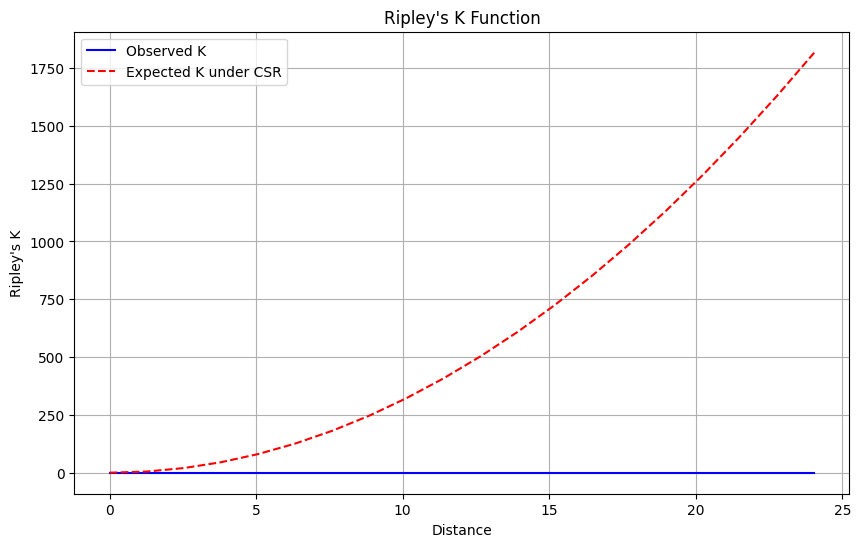


Ripley's K function plot saved as 'ripleys_k.png'
Ripley's K analysis indicates a relatively random spatial distribution


In [14]:
# 2. POINT PATTERN ANALYSIS
print("\n" + "=" * 50)
print("2. POINT PATTERN ANALYSIS")
print("=" * 50)

# Determine appropriate number of neighbors (min 2, max 10, default to 10% of points)
k_neighbors = max(2, min(10, int(n * 0.1)))
print(f"\nUsing k={k_neighbors} neighbors for nearest neighbor analysis")

# Compute nearest neighbor distances
nbrs = NearestNeighbors(n_neighbors=k_neighbors+1, algorithm='ball_tree').fit(coords)
distances, indices = nbrs.kneighbors(coords)
nearest_neighbor_distances = distances[:, 1]  # Exclude self (which is at index 0)

print("\nNearest Neighbor Distance Analysis:")
print(f"Mean nearest neighbor distance: {np.mean(nearest_neighbor_distances):.2f}")
print(f"Median nearest neighbor distance: {np.median(nearest_neighbor_distances):.2f}")
print(f"Min nearest neighbor distance: {np.min(nearest_neighbor_distances):.2f}")
print(f"Max nearest neighbor distance: {np.max(nearest_neighbor_distances):.2f}")

# Calculate point density (simple approach)
x_min, x_max = np.min(coords[:, 0]), np.max(coords[:, 0])
y_min, y_max = np.min(coords[:, 1]), np.max(coords[:, 1])
study_area = (x_max - x_min) * (y_max - y_min)
density = n / study_area

print(f"\nPoint density: {density:.10f} points per square unit")
print(f"Average distance threshold (0.5/√density): {0.5/np.sqrt(density):.2f}")

# Test for Complete Spatial Randomness (CSR) using average nearest neighbor ratio
# Under CSR, the expected mean distance is 0.5/√density
expected_mean_distance = 0.5 / np.sqrt(density)
observed_mean_distance = np.mean(nearest_neighbor_distances)
R = observed_mean_distance / expected_mean_distance

print("\nComplete Spatial Randomness Test:")
print(f"Observed mean distance: {observed_mean_distance:.2f}")
print(f"Expected mean distance under CSR: {expected_mean_distance:.2f}")
print(f"Nearest neighbor ratio (R): {R:.4f}")

if R < 1:
    print("R < 1: Points exhibit clustering")
elif R > 1:
    print("R > 1: Points exhibit dispersion")
else:
    print("R ≈ 1: Points exhibit random distribution")

# For larger datasets, use a more efficient approach for Ripley's K
def ripley_k_sample(coords, distances, n_points, study_area, sample_size=1000):
    """Calculate Ripley's K function using sampling for efficiency."""
    k_values = []
    # Sample points if there are too many
    if n_points > sample_size:
        sample_indices = np.random.choice(n_points, sample_size, replace=False)
        sample_coords = coords[sample_indices]
        n_sample = sample_size
    else:
        sample_coords = coords
        n_sample = n_points
    
    for d in distances:
        count = 0
        for i in range(n_sample):
            # Calculate distances to all other points
            dists = np.sqrt(np.sum((sample_coords[i] - coords)**2, axis=1))
            # Count points within distance d (excluding self)
            count_i = np.sum((dists <= d) & (dists > 0))
            count += count_i
        
        # Adjust the count based on the sampling
        if n_points > sample_size:
            count = count * (n_points / n_sample)
        
        k = (study_area * count) / (n_sample * n_points)
        k_values.append(k)
    
    return k_values

# Calculate distance values for Ripley's K
max_dist = np.mean(nearest_neighbor_distances) * 10
distance_values = np.linspace(0, max_dist, 20)

# Use the sampling version of Ripley's K for efficiency
print("\nCalculating Ripley's K function...")
k_values = ripley_k_sample(coords, distance_values, n, study_area, sample_size=min(1000, n))
expected_k = np.pi * distance_values**2  # Expected K under CSR

plt.figure(figsize=(10, 6))
plt.plot(distance_values, k_values, 'b-', label="Observed K")
plt.plot(distance_values, expected_k, 'r--', label="Expected K under CSR")
plt.xlabel('Distance')
plt.ylabel("Ripley's K")
plt.title("Ripley's K Function")
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('ripleys_k.png')
plt.close()

print("\nRipley's K function plot saved as 'ripleys_k.png'")

# Interpret Ripley's K
k_ratio = np.array(k_values) / expected_k
if np.mean(k_ratio) > 1.1:  # 10% more than expected
    print("Ripley's K analysis indicates clustering at multiple scales")
elif np.mean(k_ratio) < 0.9:  # 10% less than expected
    print("Ripley's K analysis indicates dispersion at multiple scales")
else:
    print("Ripley's K analysis indicates a relatively random spatial distribution")

3. SPATIAL OUTLIER DETECTION USING LOF

Using 8 neighbors for LOF...


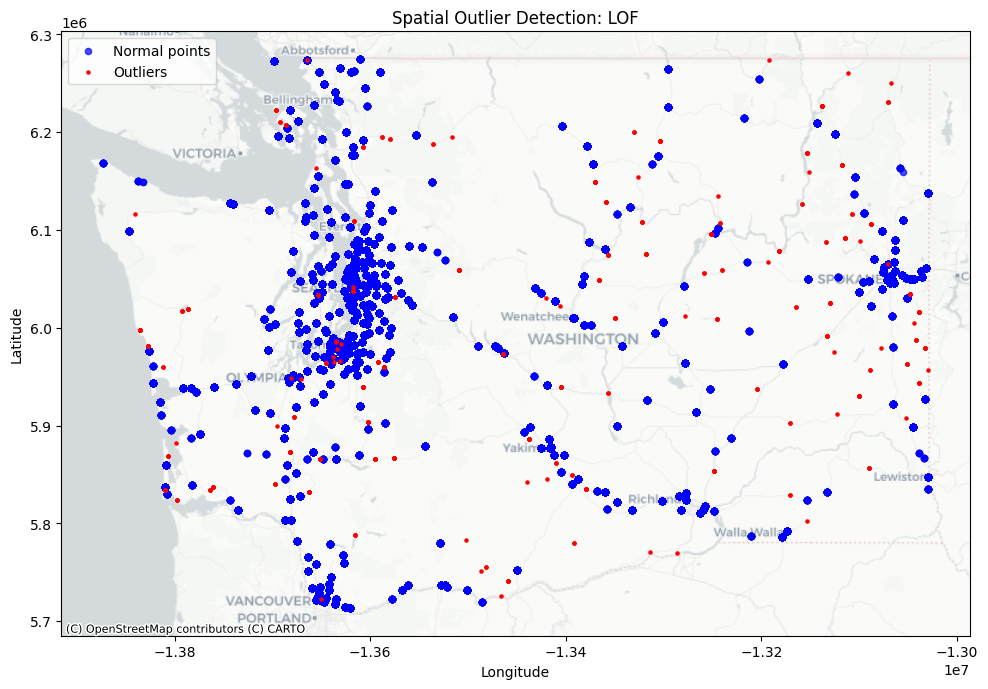


Identified 399 outliers: [   211    298   2964   7456  13607  36537  42419  47237  47399  51388
  59539  65929  67812  71020  75115  76653  78741  81803  82448  83266
  83555  87654  89512  92600  94179  94466  96638  97168  97956  98538
  98920  99409  99430  99841 100042 101793 102936 103194 103412 103512
 105595 106005 106558 107014 107117 107571 108044 108162 108231 108491
 108558 109599 109945 111189 112828 113805 113894 114429 114450 114706
 115350 116766 117617 117963 118094 118190 118225 119299 119610 120851
 121439 122019 122821 125411 125901 126037 126593 126907 127158 128024
 128157 128556 130721 131276 131328 131651 131719 131832 131977 132104
 132509 132813 132924 133494 134526 134599 134825 135699 135777 135791
 135803 135849 135987 136059 136082 136210 136248 136463 137829 138204
 138447 138472 139341 139405 139614 139865 139960 140137 140157 140262
 140365 140569 140671 140838 140874 141107 141207 141343 141544 141565
 141936 142198 142269 142440 142448 142465 142845 1

In [15]:
import numpy as np
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

print("3. SPATIAL OUTLIER DETECTION USING LOF")
print("=" * 50)

try:
    # Assume `coords` are your spatial coordinates, e.g., (x, y)
    # `y` would be your target variable (or values associated with the points)
    # Apply LOF for outlier detection
    k_for_weights = min(k_neighbors, 8)  # Use at most 8 neighbors for LOF
    print(f"\nUsing {k_for_weights} neighbors for LOF...")

    # Create LOF model
    lof = LocalOutlierFactor(n_neighbors=k_for_weights, contamination=0.1)  # Adjust contamination as needed
    outlier_flags = lof.fit_predict(coords)
    
    # LOF output: -1 means outlier, 1 means normal point
    outliers = np.where(outlier_flags == -1)[0]

    # Convert the coordinates and outlier flags to a GeoDataFrame for plotting
    gdf = gpd.GeoDataFrame({'geometry': gpd.points_from_xy(coords[:, 0], coords[:, 1]), 'outlier': outlier_flags})
    gdf['outlier'] = gdf['outlier'].map({1: 'Normal', -1: 'Outlier'})

    # Plotting the results
    fig, ax = plt.subplots(figsize=(10, 8))
    gdf[gdf['outlier'] == 'Normal'].plot(ax=ax, color='blue', markersize=20, alpha=0.7, label='Normal points')
    gdf[gdf['outlier'] == 'Outlier'].plot(ax=ax, color='red', markersize=5, label='Outliers')
    
    # Add a basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs)
    
    ax.set_title("Spatial Outlier Detection: LOF")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend()
    plt.tight_layout()
    plt.savefig('spatial_outliers_LOF.png')
    plt.show()
    plt.close()

    # Print out the identified outliers
    print(f"\nIdentified {len(outliers)} outliers: {outliers} in a total of {len(coords)} points")
    print(f"Outliers map saved as 'spatial_outliers_LOF.png'")

except Exception as e:
    print(f"\nError in LOF outlier detection: {str(e)}")
    print("Skipping spatial outlier detection...")


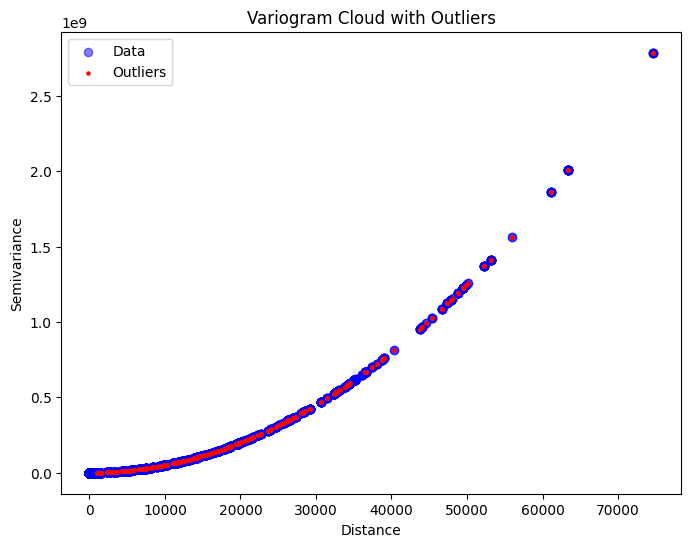

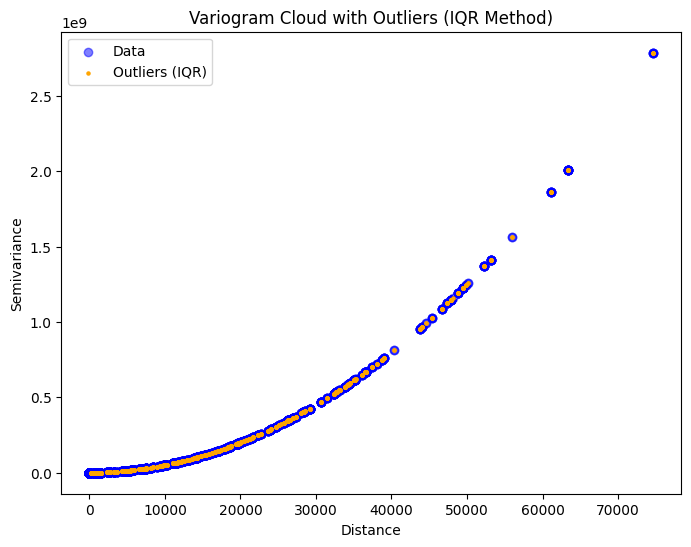

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore

# Step 1: Calculate pairwise distances and semivariance
nn = NearestNeighbors(n_neighbors=10)  # Adjust k_neighbors as needed
nn.fit(coords)
distances, indices = nn.kneighbors(coords)
semivariance = 0.5 * np.square(distances)

# Flatten the arrays for fitting and analysis
distances_flat = distances.flatten()
semivariance_flat = semivariance.flatten()

# Step 2: Fit a simple linear model (you can try exponential or other models)
# We use LinearRegression for simplicity here
model = LinearRegression()
model.fit(distances_flat.reshape(-1, 1), semivariance_flat)

# Step 3: Compute the fitted values
fitted_values = model.predict(distances_flat.reshape(-1, 1))

# Step 4: Compute residuals (observed - predicted semivariance)
residuals = semivariance_flat - fitted_values

# Step 5: Calculate Z-scores to detect outliers
z_scores = zscore(residuals)

# Define a threshold for outliers (e.g., Z-score > 3 or < -3)
outliers = np.abs(z_scores) > 3

# Step 6: Plot the variogram cloud and highlight the outliers
plt.figure(figsize=(8, 6))
plt.scatter(distances_flat, semivariance_flat, alpha=0.5, c='blue', label='Data')
plt.scatter(distances_flat[outliers], semivariance_flat[outliers], color='red', label='Outliers', s= 5)
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.title('Variogram Cloud with Outliers')
plt.legend()
plt.show()

# Optionally: You can also use IQR method to detect outliers
Q1 = np.percentile(residuals, 25)
Q3 = np.percentile(residuals, 75)
IQR = Q3 - Q1

outliers_iqr = (residuals < (Q1 - 1.5 * IQR)) | (residuals > (Q3 + 1.5 * IQR))

# Step 7: Plot again with IQR outliers
plt.figure(figsize=(8, 6))
plt.scatter(distances_flat, semivariance_flat, alpha=0.5, c='blue', label='Data')
plt.scatter(distances_flat[outliers_iqr], semivariance_flat[outliers_iqr], color='orange', label='Outliers (IQR)', s= 5)
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.title('Variogram Cloud with Outliers (IQR Method)')
plt.legend()
plt.show()


4. SPATIAL CLUSTERING

Running DBSCAN with eps=3.61 and min_samples=5...

DBSCAN clustering results:
Estimated number of clusters: 464
Estimated number of noise points: 205 (0.1%)


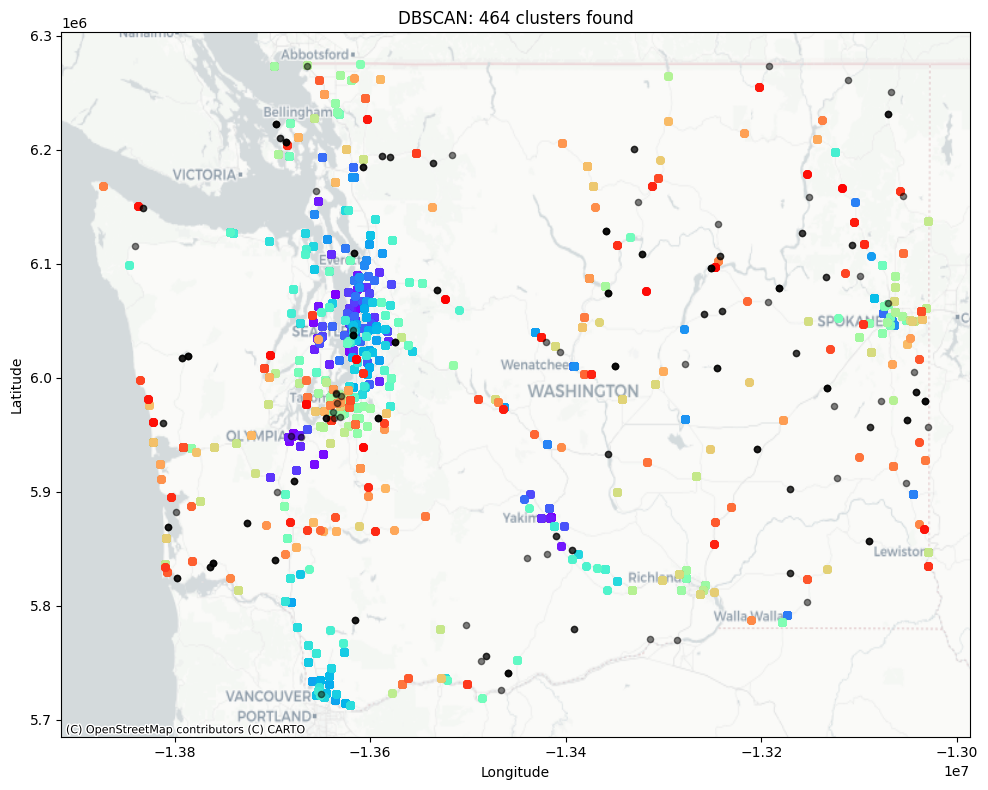


DBSCAN clustering plot saved as 'dbscan_clusters.png'

Cluster Analysis:
Cluster IDSize      Mean Electric Range Std Dev   
--------------------------------------------------
0         190       50.16               87.38     
1         351       52.65               87.27     
2         1884      47.69               79.69     
3         685       59.25               85.86     
4         478       46.40               86.37     
5         2636      45.39               82.28     
6         797       52.62               85.95     
7         877       47.27               82.95     
8         417       39.33               75.73     
9         78        48.74               80.48     
10        1867      50.10               87.15     
11        1014      47.71               80.77     
12        1588      40.92               80.30     
13        29        47.83               94.35     
14        1035      39.65               77.92     
15        236       56.39               86.90     
16      

In [16]:
# 4. SPATIAL CLUSTERING
print("\n" + "=" * 50)
print("4. SPATIAL CLUSTERING")
print("=" * 50)

# For large datasets, consider sampling for DBSCAN
max_points_for_dbscan = 300000
if n > max_points_for_dbscan:
    print(f"\nDataset too large for full DBSCAN. Sampling {max_points_for_dbscan} points...")
    sample_indices = np.random.choice(n, max_points_for_dbscan, replace=False)
    sample_coords = coords[sample_indices]
    sample_y = y[sample_indices]
else:
    sample_coords = coords
    sample_y = y
    sample_indices = np.arange(n)

# Determine DBSCAN parameters
eps = np.mean(nearest_neighbor_distances) * 1.5
min_samples = min(5, k_neighbors)  # Adjust based on density

print(f"\nRunning DBSCAN with eps={eps:.2f} and min_samples={min_samples}...")
db = DBSCAN(eps=eps, min_samples=min_samples).fit(sample_coords)
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"\nDBSCAN clustering results:")
print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise} ({n_noise/len(sample_coords)*100:.1f}%)")

# Start plotting
fig, ax = plt.subplots(figsize=(10, 8))
unique_labels = set(labels)

# Limit number of clusters shown in legend
max_clusters_in_legend = 10
large_clusters = sorted([(label, np.sum(labels == label)) 
                        for label in unique_labels if label != -1], 
                        key=lambda x: x[1], reverse=True)

top_clusters = [label for label, count in large_clusters[:max_clusters_in_legend - 1]]
top_clusters = [-1] + top_clusters  # Include noise

colors_list = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors_list):
    if k == -1:
        col = [0, 0, 0, 1]  # Black for noise
    class_member_mask = (labels == k)
    xy = sample_coords[class_member_mask]
    
    if k in top_clusters:
        if k == -1:
            ax.scatter(xy[:, 0], xy[:, 1], s=20, c=[col], alpha=0.5, label='Noise')
        else:
            ax.scatter(xy[:, 0], xy[:, 1], s=30, c=[col], label=f'Cluster {k}')
    else:
        ax.scatter(xy[:, 0], xy[:, 1], s=30, c=[col], alpha=0.6)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs)

# Format plot
ax.set_title(f'DBSCAN: {n_clusters} clusters found')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
if n_clusters < 20:
    ax.legend()
plt.tight_layout()
plt.savefig('dbscan_clusters.png')
plt.show()
plt.close()

print(f"\nDBSCAN clustering plot saved as 'dbscan_clusters.png'")

# Cluster Analysis
if n_clusters > 0:
    print("\nCluster Analysis:")
    print(f"{'Cluster ID':<10}{'Size':<10}{'Mean Electric Range':<20}{'Std Dev':<10}")
    print("-" * 50)
    
    for k in sorted(unique_labels):
        if k != -1:  # Skip noise
            cluster_mask = (labels == k)
            cluster_size = np.sum(cluster_mask)
            cluster_values = sample_y[cluster_mask]
            cluster_mean = np.mean(cluster_values)
            cluster_std = np.std(cluster_values)
            print(f"{k:<10}{cluster_size:<10}{cluster_mean:<20.2f}{cluster_std:<10.2f}")

# 4. SPATIAL CLUSTERING
# print("\n" + "=" * 50)
# print("4. SPATIAL CLUSTERING")
# print("=" * 50)

# import geopandas as gpd
# from shapely.geometry import Point
# import contextily as ctx
# from sklearn.cluster import DBSCAN

# # For large datasets, consider sampling for DBSCAN
# max_points_for_dbscan = 10000
# # if n > max_points_for_dbscan:
# #     print(f"\nDataset too large for full DBSCAN. Sampling {max_points_for_dbscan} points...")
# #     sample_indices = np.random.choice(n, max_points_for_dbscan, replace=False)
# #     sample_coords = coords[sample_indices]
# #     sample_y = y[sample_indices]
# # else:
# sample_coords = coords
# sample_y = y
# sample_indices = np.arange(n)

# # Determine DBSCAN parameters
# eps = np.mean(nearest_neighbor_distances) * 1.5
# min_samples = min(5, k_neighbors)  # Adjust based on density

# print(f"\nRunning DBSCAN with eps={eps:.2f} and min_samples={min_samples}...")
# db = DBSCAN(eps=eps, min_samples=min_samples).fit(sample_coords)
# labels = db.labels_
# n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise = list(labels).count(-1)

# print(f"\nDBSCAN clustering results:")
# print(f"Estimated number of clusters: {n_clusters}")
# print(f"Estimated number of noise points: {n_noise} ({n_noise/len(sample_coords)*100:.1f}%)")

# # Create GeoDataFrame for plotting
# gdf_dbscan = gpd.GeoDataFrame({
#     'label': labels,
#     'electric_range': sample_y
# }, geometry=[Point(xy) for xy in sample_coords], crs='EPSG:3857')

# # Plot DBSCAN clusters
# fig, ax = plt.subplots(figsize=(10, 8))

# # Limit number of clusters shown in legend
# max_clusters_in_legend = 10
# unique_labels = set(labels)
# large_clusters = sorted([(label, np.sum(labels == label)) 
#                         for label in unique_labels if label != -1], 
#                         key=lambda x: x[1], reverse=True)

# top_clusters = [label for label, count in large_clusters[:max_clusters_in_legend - 1]]
# top_clusters = [-1] + top_clusters  # Include noise

# # Plot clusters
# for k in sorted(unique_labels):
#     cluster = gdf_dbscan[gdf_dbscan['label'] == k]
#     if k in top_clusters:
#         if k == -1:
#             cluster.plot(ax=ax, color='black', markersize=20, alpha=0.5, label='Noise')
#         else:
#             cluster.plot(ax=ax, markersize=30, alpha=0.6, label=f'Cluster {k}')
#     else:
#         cluster.plot(ax=ax, markersize=30, alpha=0.6)

# # Add basemap
# ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf_dbscan.crs)

# # Format plot
# ax.set_title(f'DBSCAN: {n_clusters} clusters found')
# ax.set_xlabel('X Coordinate (EPSG:3857)')
# ax.set_ylabel('Y Coordinate (EPSG:3857)')
# if n_clusters < 20:
#     ax.legend()
# plt.tight_layout()
# plt.savefig('dbscan_clusters.png')
# plt.show()
# plt.close()

# print(f"\nDBSCAN clustering plot saved as 'dbscan_clusters.png'")

# # Cluster Analysis
# if n_clusters > 0:
#     print("\nCluster Analysis:")
#     print(f"{'Cluster ID':<10}{'Size':<10}{'Mean Electric Range':<20}{'Std Dev':<10}")
#     print("-" * 50)

#     for k in sorted(unique_labels):
#         if k != -1:  # Skip noise
#             cluster_mask = (labels == k)
#             cluster_size = np.sum(cluster_mask)
#             cluster_values = sample_y[cluster_mask]
#             cluster_mean = np.mean(cluster_values)
#             cluster_std = np.std(cluster_values)
#             print(f"{k:<10}{cluster_size:<10}{cluster_mean:<20.2f}{cluster_std:<10.2f}")

# SAR

In [53]:
from libpysal.weights import KNN
w_knn = KNN.from_dataframe(wa_ev_lattice, k=4)
w_knn.transform = 'R'

import numpy as np
from spreg import ML_Lag

# Convert to numpy arrays
y_SAR = 10*np.log10(wa_ev_lattice['ev_count'].values.reshape((-1, 1)))
X = np.ones((len(y_SAR), 1))  # Intercept-only model for now
model = ML_Lag(y_SAR, X, w=w, name_y='ev_count', name_x=['Intercept'], name_w='Queen')
print(model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :       Queen
Dependent Variable  :    ev_count                Number of Observations:          39
Mean dependent var  :     29.2347                Number of Variables   :           2
S.D. dependent var  :      9.1427                Degrees of Freedom    :          37
Pseudo R-squared    :      0.2253
Spatial Pseudo R-squared:  0.0006
Log likelihood      :   -137.4686
Sigma-square ML     :     64.2612                Akaike info criterion :     278.937
S.E of regression   :      8.0163                Schwarz criterion     :     282.264

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

Sampled 10000 records from the original dataset
Dataset shape: (10000, 20)

Distribution of Electric Vehicle Types:
Electric Vehicle Type
Battery Electric Vehicle (BEV)            7970
Plug-in Hybrid Electric Vehicle (PHEV)    2030
Name: count, dtype: int64

SPATIAL DATA EXPLORATION


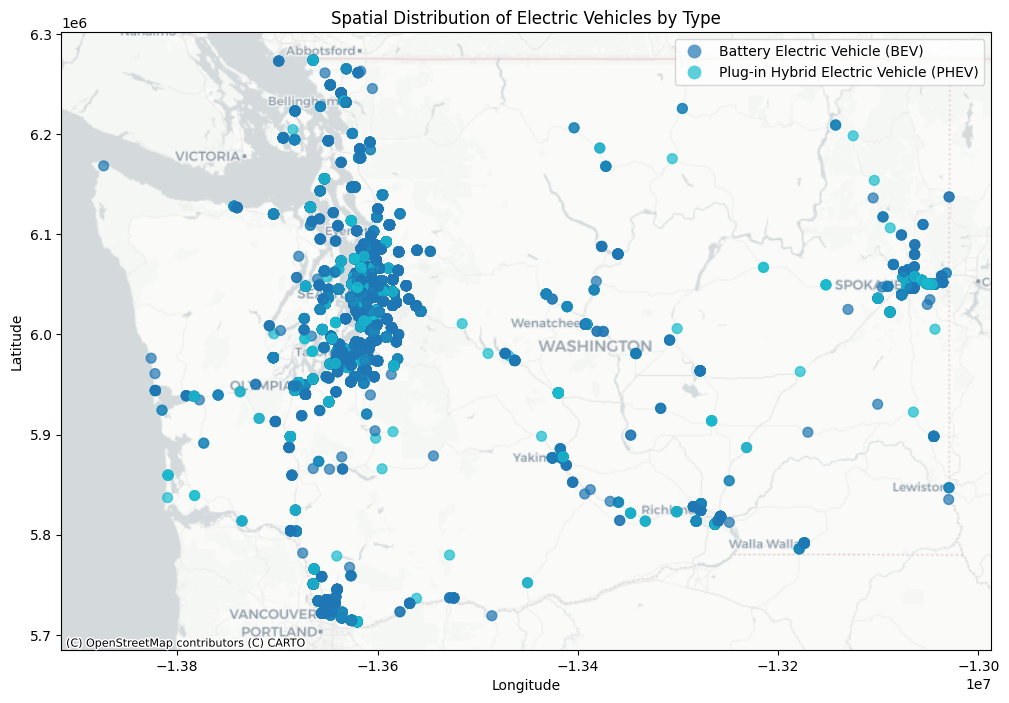


SPATIAL FEATURE ENGINEERING


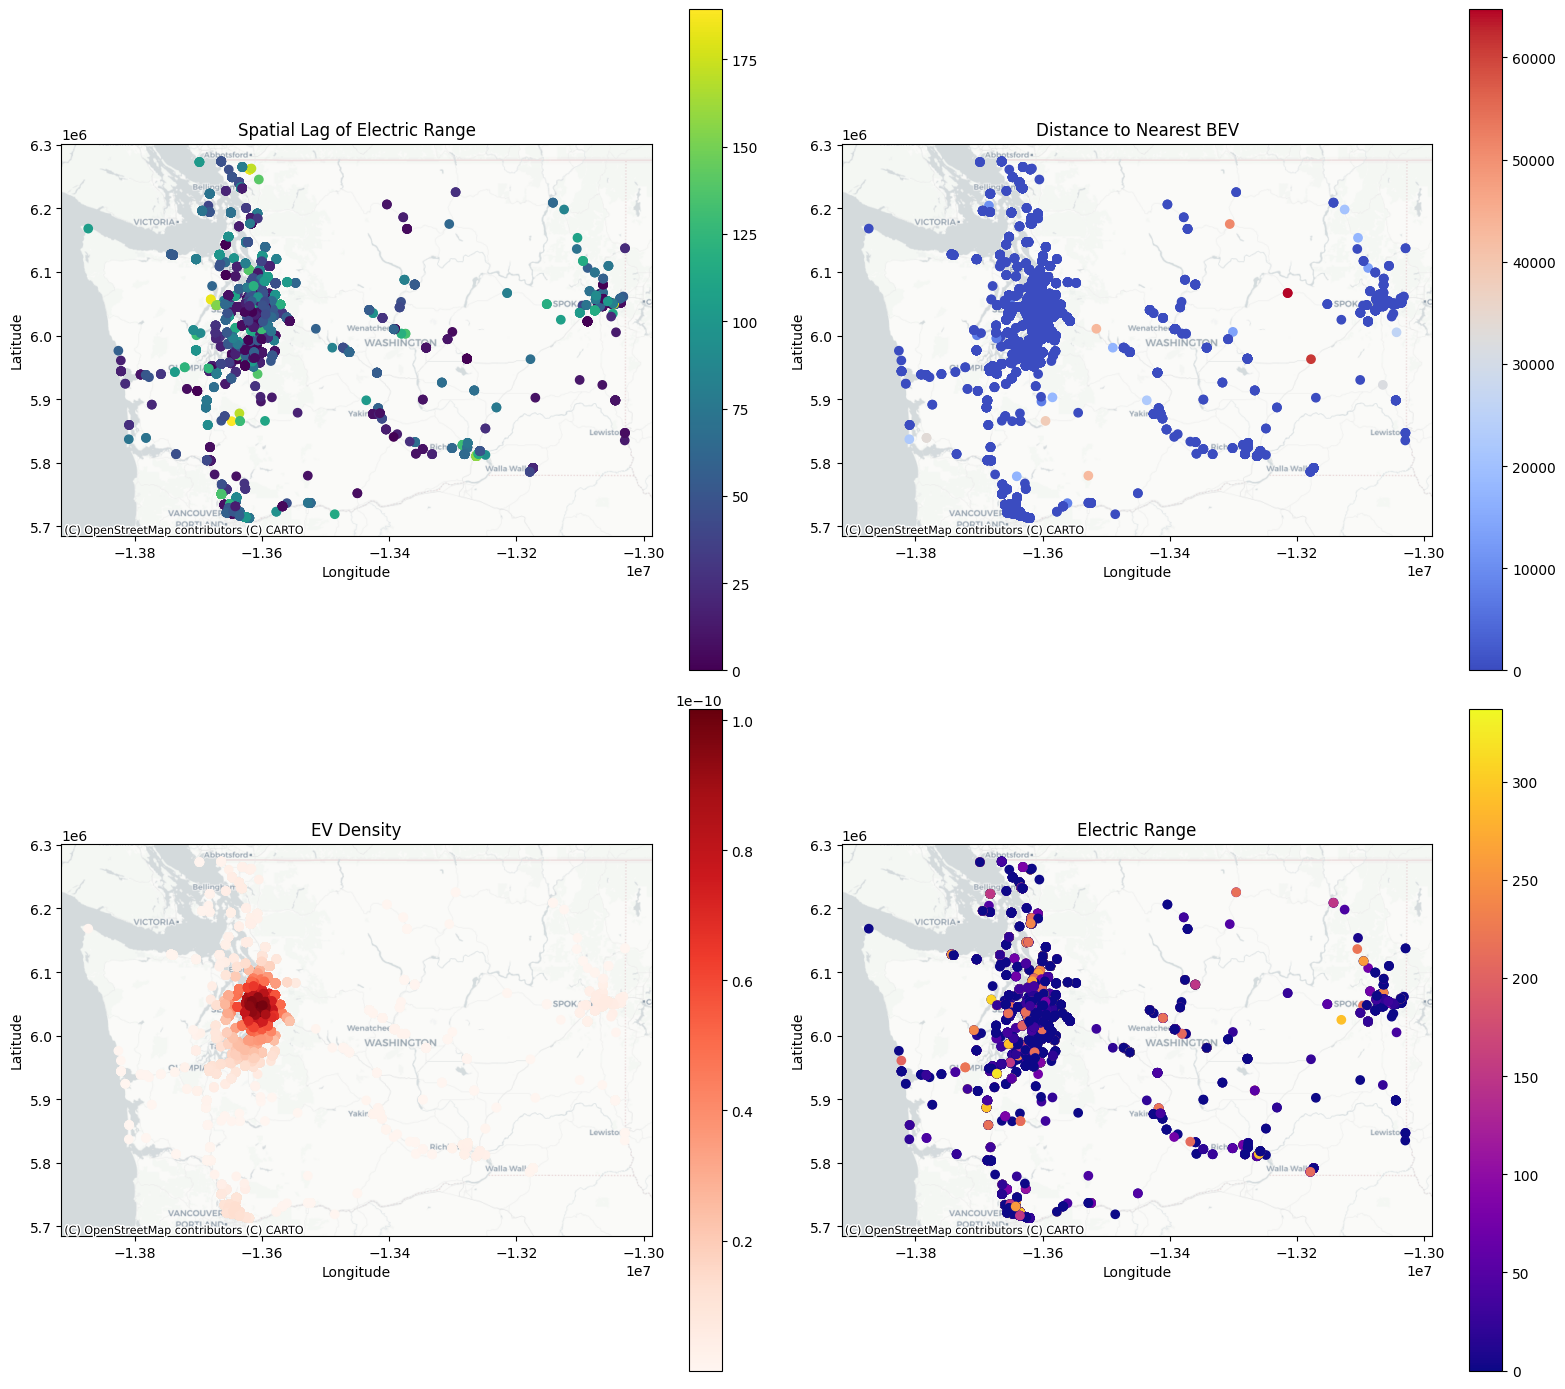

Created spatial features:
- spatial_lag_range: Average Electric Range of nearby vehicles
- dist_to_nearest_bev: Distance to nearest Battery Electric Vehicle
- ev_density: Density estimation of EVs

SPATIAL AUTOCORRELATION
Moran's I for Electric Range: 0.0083
p-value: 0.0380
There is significant spatial autocorrelation in Electric Range

SPATIAL DIMENSIONALITY REDUCTION
Explained variance ratio: [0.24167307 0.18109259]
Total explained variance: 0.4228

PCA Feature Importance:
                          PC1       PC2
longitude           -0.451719 -0.097679
latitude             0.527217  0.131740
range_values        -0.041259  0.729118
spatial_lag_range   -0.190279  0.657037
dist_to_nearest_bev -0.183241 -0.091795
ev_density           0.668212  0.036969


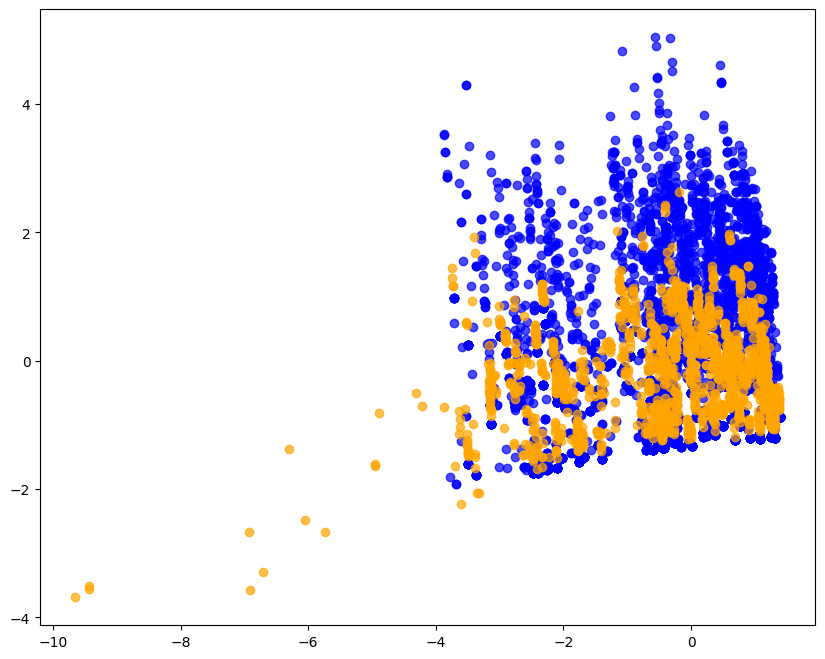


SPATIAL CLUSTERING
Number of clusters: 225


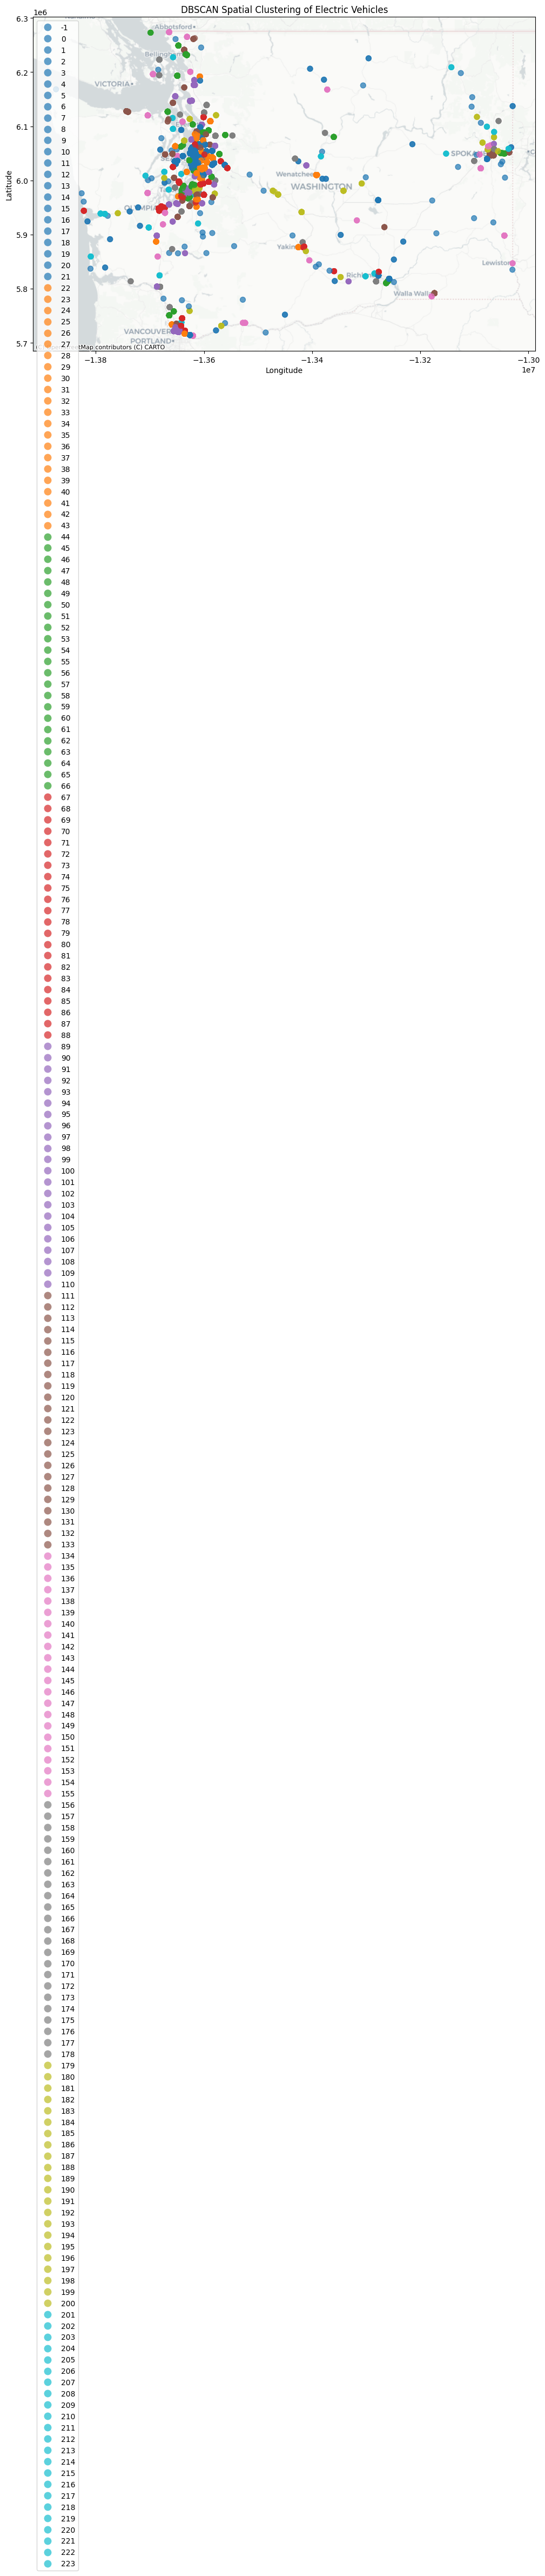


Distribution of EV Types by Cluster:
Electric Vehicle Type  Battery Electric Vehicle (BEV)  \
cluster                                                 
-1                                                 63   
 0                                                141   
 1                                                 56   
 2                                                 22   
 3                                                 63   
...                                               ...   
 219                                                3   
 220                                                3   
 221                                                3   
 222                                                4   
 223                                                2   

Electric Vehicle Type  Plug-in Hybrid Electric Vehicle (PHEV)  
cluster                                                        
-1                                                         39  
 0                          

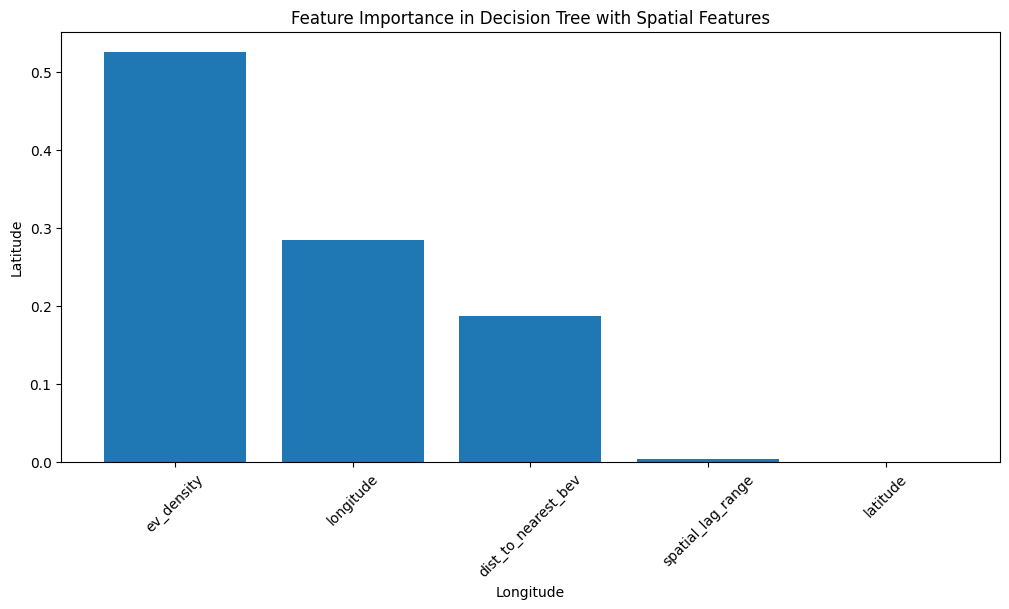


Feature Importance:
ev_density: 0.5250
longitude: 0.2844
dist_to_nearest_bev: 0.1869
spatial_lag_range: 0.0038
latitude: 0.0000

SVM WITH SPATIAL FEATURES

SVM with Spatial Features:
Accuracy: 0.8183

Classification Report:
              precision    recall  f1-score   support

        PHEV       1.00      0.02      0.03       554
         BEV       0.82      1.00      0.90      2446

    accuracy                           0.82      3000
   macro avg       0.91      0.51      0.47      3000
weighted avg       0.85      0.82      0.74      3000



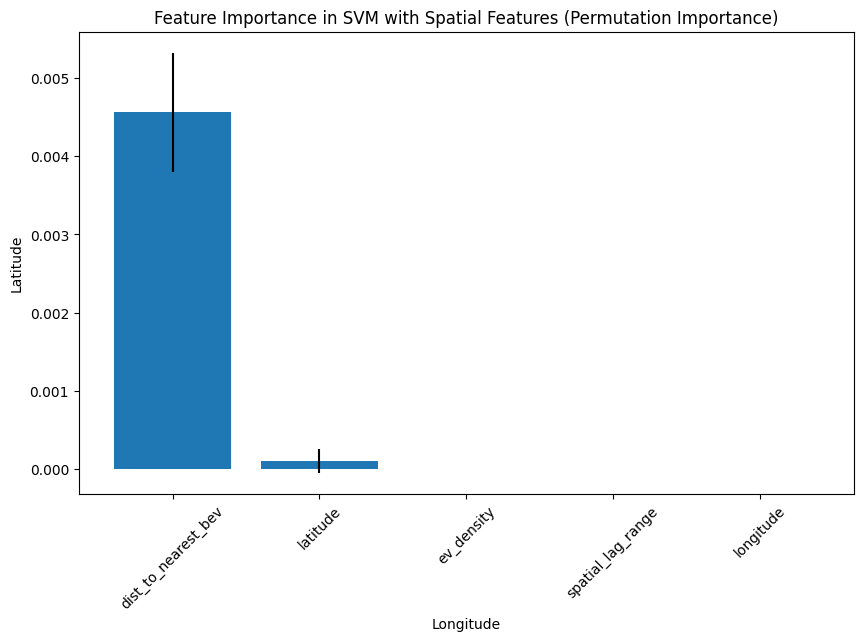


SVM Feature Importance (Permutation):
dist_to_nearest_bev: 0.0046 ± 0.0008
latitude: 0.0001 ± 0.0002
ev_density: 0.0000 ± 0.0000
spatial_lag_range: 0.0000 ± 0.0000
longitude: 0.0000 ± 0.0000

SPATIALLY WEIGHTED KNN

Distance-Weighted KNN with Spatial Features:
Accuracy: 0.7783

Classification Report:
              precision    recall  f1-score   support

        PHEV       0.29      0.14      0.19       554
         BEV       0.83      0.92      0.87      2446

    accuracy                           0.78      3000
   macro avg       0.56      0.53      0.53      3000
weighted avg       0.73      0.78      0.75      3000


MODEL COMPARISON
Decision Tree Accuracy: 0.8170
SVM Accuracy: 0.8183
Distance-Weighted KNN Accuracy: 0.7783
Baseline (DT without spatial) Accuracy: 0.9973


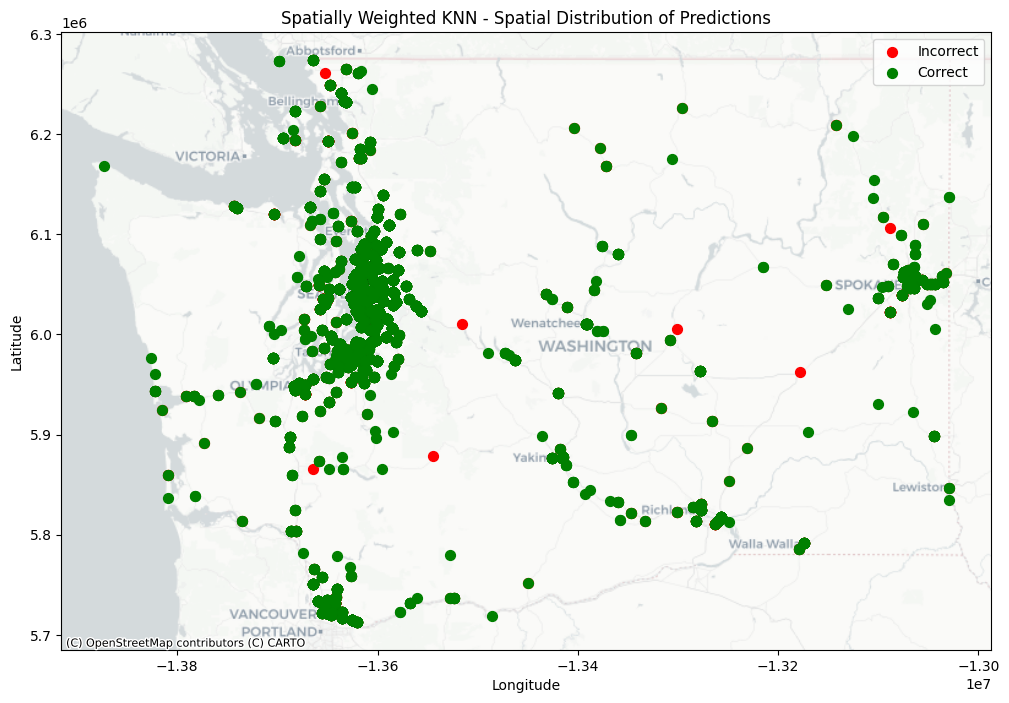


Analysis complete. All visualizations have been saved.


In [7]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import contextily as ctx
from scipy.spatial import cKDTree
from scipy.stats import gaussian_kde
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import libpysal as lps
from esda.moran import Moran
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings("ignore")

# Load and prepare the data
df = pd.read_csv('./Electric_Vehicle_Population_Data.csv')
df.dropna(inplace=True)

# Extract Latitude and Longitude from 'Vehicle Location'
df['Longitude'] = df['Vehicle Location'].str.extract(r'POINT \(([^ ]+)')[0].astype(float)
df['Latitude'] = df['Vehicle Location'].str.extract(r'POINT \([^)]+ ([^)]+)')[0].astype(float)
df.dropna(subset=['Longitude', 'Latitude'], inplace=True)

# OPTIONAL: If the dataset is too large, sample a subset
# Adjust sample_size based on your system's memory capacity
sample_size = 10000  # Or other appropriate size
if len(df) > sample_size:
    df = df.sample(sample_size, random_state=42)
    print(f"Sampled {sample_size} records from the original dataset")

# Prepare spatial data
df['geometry'] = df.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326").to_crs(epsg=3857)

# Print basic information
print(f"Dataset shape: {df.shape}")
print("\nDistribution of Electric Vehicle Types:")
print(df['Electric Vehicle Type'].value_counts())

# Extract spatial coordinates
gdf['longitude'] = gdf.geometry.x
gdf['latitude'] = gdf.geometry.y

print("\n===========================")
print("SPATIAL DATA EXPLORATION")
print("===========================")

# Create a plot of vehicle locations
fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(column='Electric Vehicle Type', categorical=True, legend=True, ax=ax, alpha=0.7, markersize=50)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
plt.title('Spatial Distribution of Electric Vehicles by Type')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.savefig('ev_spatial_distribution.png', bbox_inches='tight', dpi=300)
plt.close()

##################################################
# 1. SPATIAL FEATURE ENGINEERING (Map Synthesis)
##################################################
print("\n===========================")
print("SPATIAL FEATURE ENGINEERING")
print("===========================")

# Replace cdist with KDTree for efficient nearest neighbor queries
coords = np.column_stack((gdf['longitude'], gdf['latitude']))
kdtree = cKDTree(coords)

# Find k nearest neighbors for each point
k = 5  # Number of neighbors
# kdtree.query returns (distances, indices)
_, neighbor_indices = kdtree.query(coords, k=k+1)  # +1 because first neighbor is self

# 1.1 Create Spatial Summary Features
# Average Electric Range of neighboring vehicles
gdf['range_values'] = pd.to_numeric(gdf['Electric Range'], errors='coerce').fillna(0)
spatial_lag_range = np.zeros(len(gdf))

for i in range(len(gdf)):
    # Skip the first neighbor (which is the point itself)
    neighbors = neighbor_indices[i, 1:]
    if len(neighbors) > 0:
        spatial_lag_range[i] = gdf.iloc[neighbors]['range_values'].mean()
    else:
        spatial_lag_range[i] = gdf['range_values'].mean()  # Global mean as fallback
    
gdf['spatial_lag_range'] = spatial_lag_range

# 1.2 Create Proximity Features
# Distance to the nearest BEV (Battery Electric Vehicle)
gdf['is_bev'] = gdf['Electric Vehicle Type'] == 'Battery Electric Vehicle (BEV)'
bev_indices = np.where(gdf['is_bev'])[0]

if len(bev_indices) > 0:
    bev_coords = coords[bev_indices]
    # For each point, find distance to nearest BEV
    distances_to_bev, _ = cKDTree(bev_coords).query(coords, k=1)
    gdf['dist_to_nearest_bev'] = distances_to_bev
else:
    gdf['dist_to_nearest_bev'] = 0

# 1.3 Create Density Features
# Kernel density estimation of EV density
# For large datasets, consider sampling or grid-based approach
try:
    kde = gaussian_kde(coords.T)
    gdf['ev_density'] = kde(coords.T)
except:
    print("Warning: KDE failed, using simple point density instead")
    # Simple alternative: count of points within a radius
    radius = 5000  # meters
    density = np.zeros(len(gdf))
    for i in range(len(gdf)):
        neighbors = kdtree.query_ball_point(coords[i], radius)
        density[i] = len(neighbors) / (np.pi * radius**2)
    gdf['ev_density'] = density

# Visualize the created spatial features
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot Spatial Lag of Electric Range
gdf.plot(column='spatial_lag_range', cmap='viridis', legend=True, ax=axes[0, 0])
axes[0, 0].set_title('Spatial Lag of Electric Range')

# Plot Distance to Nearest BEV
gdf.plot(column='dist_to_nearest_bev', cmap='coolwarm', legend=True, ax=axes[0, 1])
axes[0, 1].set_title('Distance to Nearest BEV')

# Plot EV Density
gdf.plot(column='ev_density', cmap='Reds', legend=True, ax=axes[1, 0])
axes[1, 0].set_title('EV Density')

# Plot Electric Range
gdf.plot(column='range_values', cmap='plasma', legend=True, ax=axes[1, 1])
axes[1, 1].set_title('Electric Range')

for ax in axes.flatten():
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
 
plt.tight_layout()
plt.show()
plt.savefig('spatial_features.png', bbox_inches='tight', dpi=300)
plt.close()

print("Created spatial features:")
print("- spatial_lag_range: Average Electric Range of nearby vehicles")
print("- dist_to_nearest_bev: Distance to nearest Battery Electric Vehicle")
print("- ev_density: Density estimation of EVs")

##################################################
# 2. SPATIAL AUTOCORRELATION
##################################################
print("\n===========================")
print("SPATIAL AUTOCORRELATION")
print("===========================")

# Create weights object using KNN approach with libpysal
# For large datasets, consider sampling for Moran's I computation
try:
    # Create libpysal KNN weights using the neighbor indices we already computed
    from libpysal.weights import KNN
    knn = KNN.from_dataframe(gdf, k=5)
    
    # Calculate Moran's I for Electric Range
    moran = Moran(gdf['range_values'], knn)
    print(f"Moran's I for Electric Range: {moran.I:.4f}")
    print(f"p-value: {moran.p_sim:.4f}")
    
    if moran.p_sim < 0.05:
        print("There is significant spatial autocorrelation in Electric Range")
    else:
        print("No significant spatial autocorrelation detected in Electric Range")
except Exception as e:
    print(f"Warning: Moran's I calculation failed: {e}")
    print("Consider sampling your data or using an alternative approach")

##################################################
# 3. SPATIAL DIMENSIONALITY REDUCTION
##################################################
print("\n===========================")
print("SPATIAL DIMENSIONALITY REDUCTION")
print("===========================")

# Prepare data for PCA
numeric_cols = ['longitude', 'latitude', 'range_values', 'spatial_lag_range', 
                'dist_to_nearest_bev', 'ev_density']
X_pca = gdf[numeric_cols].copy()

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
gdf['pca1'] = pca_result[:, 0]
gdf['pca2'] = pca_result[:, 1]

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.4f}")

# Feature importance in PCA
feature_importance = pd.DataFrame(
    pca.components_.T, 
    columns=[f'PC{i+1}' for i in range(2)],
    index=numeric_cols
)
print("\nPCA Feature Importance:")
print(feature_importance)

# Plot PCA results
plt.figure(figsize=(10, 8))
colors = {'Battery Electric Vehicle (BEV)': 'blue', 'Plug-in Hybrid Electric Vehicle (PHEV)': 'orange'}
for ev_type in gdf['Electric Vehicle Type'].unique():
    mask = gdf['Electric Vehicle Type'] == ev_type
    plt.scatter(gdf.loc[mask, 'pca1'], gdf.loc[mask, 'pca2'], c=colors.get(ev_type, 'gray'), 
                label=ev_type, alpha=0.7)
plt.show()
plt.legend()
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of Spatial Features by EV Type')
plt.savefig('pca_spatial_features.png', bbox_inches='tight')
plt.close()

##################################################
# 4. SPATIAL CLUSTERING (DBSCAN)
##################################################
print("\n===========================")
print("SPATIAL CLUSTERING")
print("===========================")

# Prepare data for clustering
X_cluster = gdf[['longitude', 'latitude']].values

# DBSCAN - Density-Based Spatial Clustering
# eps is the maximum distance between two samples for one to be considered in the neighborhood of the other
# min_samples is the number of samples in a neighborhood for a point to be considered a core point
dbscan = DBSCAN(eps=5000, min_samples=3)  # Adjust eps based on your coordinate system
gdf['cluster'] = dbscan.fit_predict(X_cluster)

# Count number of clusters (excluding noise points labeled as -1)
n_clusters = len(set(gdf['cluster'])) - (1 if -1 in gdf['cluster'] else 0)
print(f"Number of clusters: {n_clusters}")

# Plot clustering results
fig, ax = plt.subplots(figsize=(12, 10))
scatter = gdf.plot(column='cluster', categorical=True, legend=True, 
                  alpha=0.7, markersize=50, ax=ax)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
plt.title('DBSCAN Spatial Clustering of Electric Vehicles')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()
plt.savefig('spatial_clustering.png', bbox_inches='tight', dpi=300)
plt.close()

# Cross-tabulate clusters with EV types
cluster_ev_type = pd.crosstab(gdf['cluster'], gdf['Electric Vehicle Type'])
print("\nDistribution of EV Types by Cluster:")
print(cluster_ev_type)

##################################################
# 5. DECISION TREES WITH SPATIAL FEATURES
##################################################
print("\n===========================")
print("DECISION TREES WITH SPATIAL FEATURES")
print("===========================")

# Prepare features and target
# Target: Predict EV Type (BEV vs PHEV)
# Binary classification
gdf['target'] = (gdf['Electric Vehicle Type'] == 'Battery Electric Vehicle (BEV)').astype(int)

# Prepare feature set - include spatial features
X = gdf[['longitude', 'latitude', 'spatial_lag_range', 
         'dist_to_nearest_bev', 'ev_density']].values
y = gdf['target'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Decision Tree with spatial features
dt_spatial = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_spatial.fit(X_train, y_train)

# Make predictions
y_pred = dt_spatial.predict(X_test)

# Evaluate
print("\nDecision Tree with Spatial Features:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['PHEV', 'BEV']))

# Compare with baseline model (without spatial features)
X_baseline = gdf[['range_values']].values
X_train_baseline, X_test_baseline, y_train, y_test = train_test_split(
    X_baseline, y, test_size=0.3, random_state=42)

dt_baseline = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_baseline.fit(X_train_baseline, y_train)
y_pred_baseline = dt_baseline.predict(X_test_baseline)

print("\nBaseline Decision Tree (without spatial features):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")

# Feature importance
feature_names = ['longitude', 'latitude', 'spatial_lag_range', 
                'dist_to_nearest_bev', 'ev_density']
importances = dt_spatial.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importance in Decision Tree with Spatial Features')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.savefig('dt_feature_importance.png', bbox_inches='tight')
plt.close()

print("\nFeature Importance:")
for i in indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

##################################################
# 6. SUPPORT VECTOR MACHINE WITH SPATIAL FEATURES
##################################################
print("\n===========================")
print("SVM WITH SPATIAL FEATURES")
print("===========================")

# Create pipeline with standardization and SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42))
])

# Train SVM with spatial features
pipeline.fit(X_train, y_train)
y_pred_svm = pipeline.predict(X_test)

# Evaluate
print("\nSVM with Spatial Features:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['PHEV', 'BEV']))

# Feature importance for SVM (using permutation importance)
perm_importance = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importance in SVM with Spatial Features (Permutation Importance)')
plt.bar(range(len(feature_names)), perm_importance.importances_mean[sorted_idx], yerr=perm_importance.importances_std[sorted_idx], align='center')
plt.xticks(range(len(feature_names)), [feature_names[i] for i in sorted_idx], rotation=45)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.tight_layout()
plt.savefig('svm_feature_importance.png', bbox_inches='tight')
plt.close()

print("\nSVM Feature Importance (Permutation):")
for i in sorted_idx:
    print(f"{feature_names[i]}: {perm_importance.importances_mean[i]:.4f} ± {perm_importance.importances_std[i]:.4f}")

##################################################
# 7. SPATIALLY WEIGHTED K-NEAREST NEIGHBORS
##################################################
print("\n===========================")
print("SPATIALLY WEIGHTED KNN")
print("===========================")

# Create distance-weighted KNN classifier
knn_clf = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_clf.fit(X_train, y_train)
y_pred_knn = knn_clf.predict(X_test)

# Evaluate
print("\nDistance-Weighted KNN with Spatial Features:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, target_names=['PHEV', 'BEV']))

# Get prediction probabilities
y_prob_knn = knn_clf.predict_proba(X_test)[:, 1]

# Create a comparison of all models
print("\n===========================")
print("MODEL COMPARISON")
print("===========================")
models = {
    'Decision Tree': y_pred,
    'SVM': y_pred_svm,
    'Distance-Weighted KNN': y_pred_knn,
    'Baseline (DT without spatial)': y_pred_baseline
}

for name, predictions in models.items():
    acc = accuracy_score(y_test, predictions)
    print(f"{name} Accuracy: {acc:.4f}")

# Function to visualize model predictions on map
def plot_spatial_predictions(model, X_map, features, gdf, title):
    # Make predictions for all data points
    y_pred_map = model.predict(X_map)
    
    # Create a copy of the geodataframe with predictions
    gdf_pred = gdf.copy()
    gdf_pred['predicted'] = y_pred_map
    gdf_pred['correct'] = gdf_pred['predicted'] == gdf_pred['target']
    
    # Create a map with predictions
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot incorrect predictions in red, correct in green
    gdf_pred[gdf_pred['correct'] == False].plot(color='red', markersize=50, 
                                               label='Incorrect', ax=ax)
    gdf_pred[gdf_pred['correct'] == True].plot(color='green', markersize=50, 
                                              label='Correct', ax=ax)
    
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    plt.title(f'{title} - Spatial Distribution of Predictions')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.legend()
    plt.show()
    plt.savefig(f'{title.lower().replace(" ", "_")}_predictions.png', bbox_inches='tight', dpi=300)
    plt.close()

# Prepare all data for visualization
X_all = gdf[['longitude', 'latitude', 'spatial_lag_range', 
            'dist_to_nearest_bev', 'ev_density']].values

# Visualize predictions of the best model (choose based on highest accuracy)
# best_model = knn_clf  # Change this to the best model based on results
plot_spatial_predictions(knn_clf, X_all, feature_names, gdf, "Spatially Weighted KNN")

print("\nAnalysis complete. All visualizations have been saved.")

7998
10000


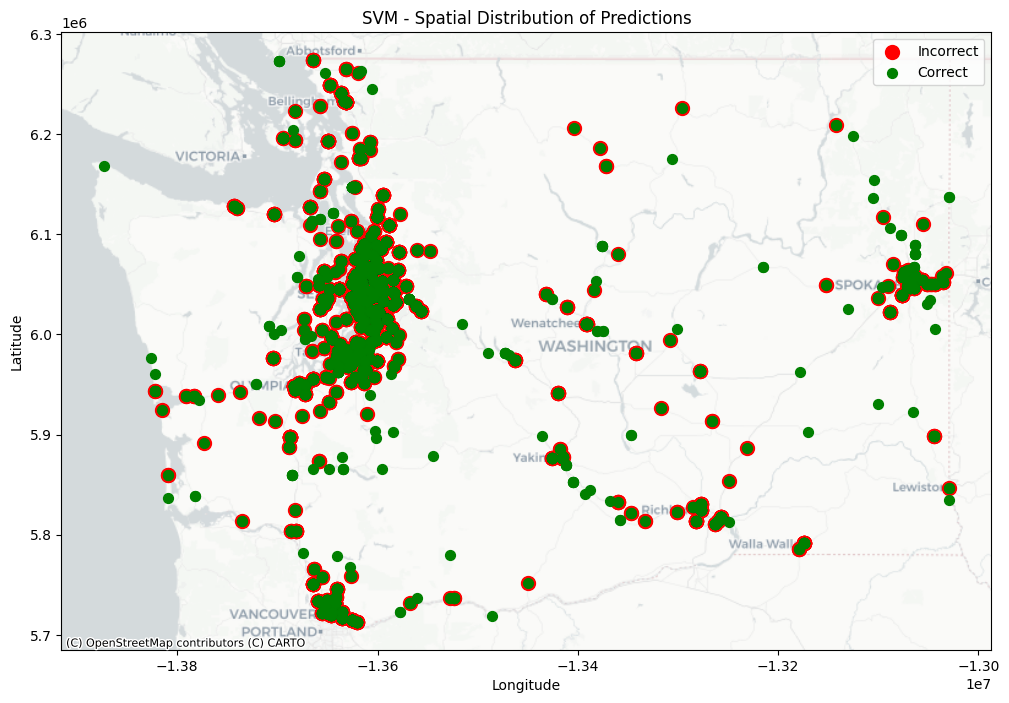


Analysis complete. All visualizations have been saved.


In [8]:
def plot_spatial_predictions(model, X_map, features, gdf, title):
    # Make predictions for all data points
    y_pred_map = model.predict(X_map)
    
    # Create a copy of the geodataframe with predictions
    gdf_pred = gdf.copy()
    gdf_pred['predicted'] = y_pred_map
    gdf_pred['correct'] = gdf_pred['predicted'] == gdf_pred['target']
    print(sum(gdf_pred['correct'] == True))
    print(len(gdf_pred))
    # Create a map with predictions
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot incorrect predictions in red, correct in green
    gdf_pred[gdf_pred['correct'] == False].plot(color='red', markersize=100, 
                                               label='Incorrect', ax=ax)
    gdf_pred[gdf_pred['correct'] == True].plot(color='green', markersize=50, 
                                              label='Correct', ax=ax)
    
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    plt.title(f'{title} - Spatial Distribution of Predictions')
    plt.legend()
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()
    plt.savefig(f'{title.lower().replace(" ", "_")}_predictions.png', bbox_inches='tight', dpi=300)
    plt.close()
best_model = pipeline  # Change this to the best model based on results
plot_spatial_predictions(best_model, X_all, feature_names, gdf, "SVM")

print("\nAnalysis complete. All visualizations have been saved.")